# 데이터 로드

In [1]:
import FinanceDataReader as fdr

# 데이터로드

stock_list = pd.read_csv('../data/stock_list.csv')
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list.head()

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI


In [181]:
start_date = '20200101'
end_date = '20201231'
sample_code = '005930'
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921
...,...,...,...,...,...,...
2020-12-23,72400,74000,72300,73900,19411326,0.022130
2020-12-24,74100,78800,74000,77800,32502870,0.052774
2020-12-28,79000,80100,78200,78700,40085044,0.011568


In [182]:
sample_code = '000060'
sample_code

'000060'

In [224]:
start_date = '20210104'
end_date = '20211105'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
NUM of WEEKS to "end_date" : 44
HOW MANY "Business_days" : (220, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [225]:
# DF생성

sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample.set_index('Date', inplace=True)
sample

,Close
Date,
2021-01-04,14250.0
2021-01-05,14050.0
2021-01-06,14250.0
2021-01-07,14700.0
2021-01-08,14750.0
...,...
2021-11-01,27850.0
2021-11-02,29250.0
2021-11-03,30250.0


In [226]:
sample.isnull().sum()

Close    11
dtype: int64

In [227]:
sample = sample.fillna(sample.Close.mean())

# Train, Test set

In [228]:

# 10-29 일까지의 데이터를 학습데이터로 사용
train_df = sample.iloc[:-5]

# 11-1 ~ 11-5 일까지의 데이터를 테스트데이터로 샤용
test_df = sample.iloc[-5:]

In [229]:
train_df.isnull().sum()

Close    0
dtype: int64

# ARIMA Model

In [263]:
# ARIMA

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR = 2, 차분 = 1, MA = 2) 파라미터로 ARIMA 모델 학습
model = ARIMA(train_df.Close.values, order = (3,1,0))

model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  214
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1892.878
Method:                       css-mle   S.D. of innovations           1678.475
Date:                Sun, 28 Nov 2021   AIC                           3795.756
Time:                        13:57:10   BIC                           3812.586
Sample:                             1   HQIC                          3802.556
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.5553     62.900      1.058      0.290     -56.727     189.837
ar.L1.D.y     -0.3728      0.067     -5.554      0.000      -0.504      -0.241
ar.L2.D.y     -0.2698      0.069     -3.899      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


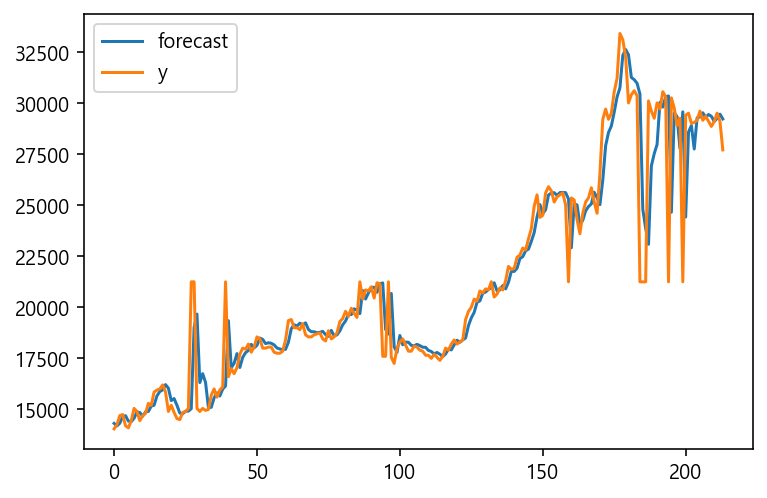

In [264]:
fig = model_fit.plot_predict()

<AxesSubplot:title={'center':'실제값과 예측값의 잔차'}>

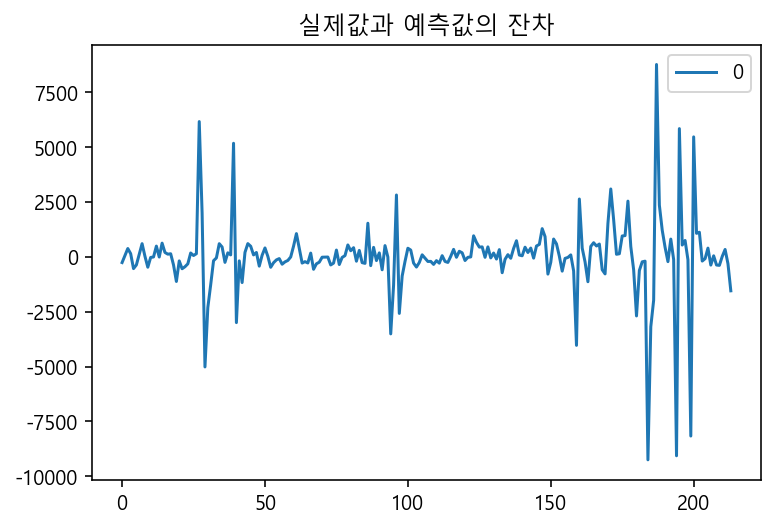

In [260]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='실제값과 예측값의 잔차')

In [62]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

forecast_data = model_fit.forecast(steps=5)

mae = mean_absolute_error(test_df.Close.values, forecast_data[0])
mse = mean_squared_error(test_df.Close.values, forecast_data[0])
rmse = np.sqrt(mse)

print('mae:' ,mae)
print('mse:' ,mse)
print('rmse:' ,rmse)

NameError: name 'model_fit' is not defined

In [262]:
# 마지막 5일 예측 데이터
pred_arima_y = forecast_data[0].tolist()

# 실제 5일 데이터
test_y = test_df.Close.values

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

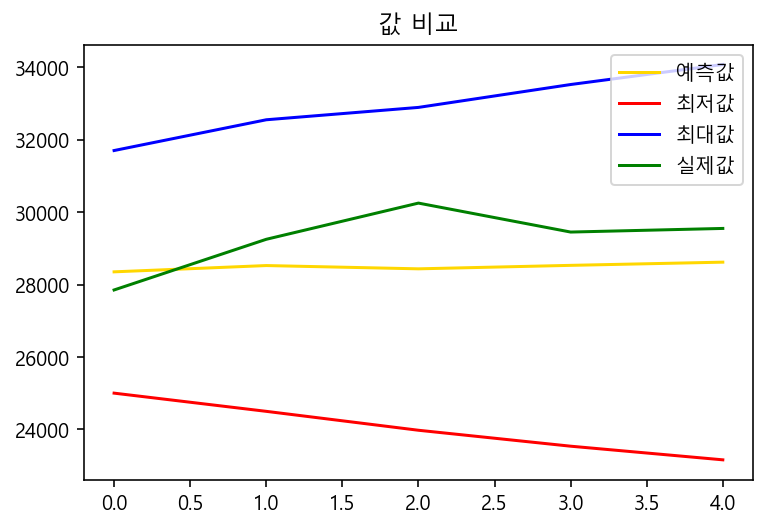

In [252]:
# 모델이 예측한 가격 그래프
plt.plot(pred_arima_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")
plt.show()

# Make Submission File

In [265]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission.head()

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [266]:
first_sample = sample_submission.iloc[:-5]
second_sample = sample_submission.iloc[5:]

In [271]:
from tqdm import tqdm

for code in tqdm(stock_list['종목코드'].values):
    # DF생성
    forecast_datas = []
    sample = fdr.DataReader(code, start = start_date, end = end_date)[['Close']].reset_index()
    sample = pd.merge(Business_days, sample, how = 'outer')
    sample.set_index('Date', inplace=True)
    sample = sample.fillna(sample.Close.mean())
    
    # 10-29 일까지의 데이터를 학습데이터로 사용
    train_df = sample.iloc[:-5]

    # 11-1 ~ 11-5 일까지의 데이터를 테스트데이터로 샤용
    test_df = sample.iloc[-5:]

    model = ARIMA(train_df.Close.values, order = (2,1,0))
    model_fit = model.fit(trend = 'c', full_output = True, disp = True)
    forecast_data = model_fit.forecast(steps=5)

    # 마지막 5일 예측 데이터
    pred_arima_y = forecast_data[0].tolist()
    print(pred_arima_y)
    first_sample.loc[:, code] = pred_arima_y
first_sample

  0%|                                                                                          | 0/370 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Kim\AppData\Roaming\Python\Python3

[69899.89352907843, 69917.4461196514, 69806.31388908143, 69748.34729167914, 69693.56559387117]


  1%|▍                                                                                 | 2/370 [00:00<01:33,  3.94it/s]

[103172.07045565938, 103710.15489688035, 103250.09045122286, 103135.69446880059, 103101.08362252827]
[409035.7223355505, 409790.76040988223, 410155.95255325345, 410704.9306935912, 411247.90429976286]

  1%|▉                                                                                 | 4/370 [00:00<01:14,  4.91it/s]


[126181.6543906756, 126334.7718321944, 126500.10961443836, 126732.94798678793, 126951.10254267234]
[878154.3979434057, 876640.385977027, 877028.1435410624, 877269.0922205172, 877433.8402448918]
[64194.409960808516, 64268.18884856018, 64154.79078863505, 64107.64244971184, 64068.64657799841]

  2%|█▌                                                                                | 7/370 [00:01<01:00,  6.04it/s]


[834528.1983096512, 836188.4281615738, 835823.3701571834, 835351.9236043579, 835150.9273917838]


  2%|█▉                                                                                | 9/370 [00:01<00:56,  6.40it/s]

[738147.2866654182, 739297.7751214638, 738786.2372271386, 739161.0961545543, 739556.4478712674]
[208726.72830196368, 208874.67145420655, 208765.76170361752, 208765.92447738312, 208782.44493720145]


  3%|██▏                                                                              | 10/370 [00:01<00:55,  6.47it/s]

[204129.25156499096, 204875.28416596024, 203028.58810523545, 202391.85033186027, 201900.75963849202]


  3%|██▋                                                                              | 12/370 [00:02<01:00,  5.91it/s]

[85312.97181273488, 85399.63698044948, 85500.47258113594, 85599.71865360318, 85699.14302647332]
[298654.75575075636, 298484.52599676186, 298393.903529689, 298600.4126737162, 298697.0389824162]


  4%|███                                                                              | 14/370 [00:02<01:03,  5.59it/s]

[120714.73629051844, 120666.78759477565, 120533.5571874658, 120441.90228918607, 120348.01293649034]
[114951.33179891064, 114638.14857057181, 114496.7228732045, 114373.19946171602, 114234.34484892193]


  4%|███▎                                                                             | 15/370 [00:02<01:04,  5.50it/s]

[254627.00925465033, 256499.22926488327, 255405.56286876972, 255004.5489271995, 255131.2836415992]
[242834.95806558145, 242907.5880935078, 242950.4624296628, 243002.83938448536, 243055.71523558724]

  5%|███▋                                                                             | 17/370 [00:03<01:02,  5.61it/s]


[1175819.8060594902, 1173637.0557683918, 1170647.8233508572, 1168787.4377384896, 1166815.644019147]


  5%|████▏                                                                            | 19/370 [00:03<01:04,  5.46it/s]

[309978.9267937212, 310310.20069005474, 310604.0841005382, 310935.05664788454, 311261.067672965]
[57104.36541174777, 57149.834468235174, 57186.13464316216, 57263.22894418846, 57329.30584436687]


  5%|████▍                                                                            | 20/370 [00:03<01:03,  5.53it/s]

[38560.37813776709, 38580.29590157579, 38566.236755424616, 38612.545612842936, 38647.845116849734]
[243497.89244666437, 243495.59950558818, 243450.68394069868, 243420.7434680243, 243390.1405763735]

  6%|████▊                                                                            | 22/370 [00:03<00:56,  6.19it/s]


[625740.6153742257, 622729.9142066499, 621441.0896308977, 619919.9945316392, 618186.0992761473]


  6%|█████▎                                                                           | 24/370 [00:04<01:01,  5.60it/s]

[26770.963027955142, 26810.71717185531, 26846.02555136278, 26899.023314123453, 26948.51744567201]
[22596.701998773253, 22569.919671184103, 22552.184671290066, 22531.344798257698, 22511.597766401897]


  7%|█████▋                                                                           | 26/370 [00:04<01:00,  5.66it/s]

[68138.56633799727, 68084.12996802179, 67857.631401167, 67891.2677529784, 67850.17665131608]
[154548.38677974584, 154019.5834988708, 153610.20885636116, 153581.18308314402, 153371.29030646468]


  8%|██████▏                                                                          | 28/370 [00:05<00:59,  5.73it/s]

[159485.4520135672, 160398.87579550035, 160007.3443901136, 159840.16382500384, 159810.19761490432]
[182777.93550544983, 182646.40163044058, 182360.16562843006, 182344.3109224374, 182234.19155216785]


  8%|██████▎                                                                          | 29/370 [00:05<00:59,  5.77it/s]

[45352.397080602794, 45400.15133246972, 45398.12491087939, 45469.04923971714, 45529.00083829132]
[123672.61670278269, 123567.48671846488, 123547.28605742808, 123510.14127845135, 123475.19279215112]


  8%|██████▊                                                                          | 31/370 [00:05<00:53,  6.32it/s]

[145406.98243805912, 145574.00752094455, 145672.3663108155, 145804.85220887535, 145924.49154909793]
[338367.5261796893, 338295.02807278855, 338974.5314783363, 340014.46764569246, 340811.56256786623]


  9%|███████▏                                                                         | 33/370 [00:05<00:51,  6.61it/s]

[24565.637454583957, 24557.553241204285, 24612.606773529944, 24665.028840928615, 24711.462218197714]


  9%|███████▍                                                                         | 34/370 [00:05<00:56,  5.93it/s]

[102861.39017278816, 102856.71659709896, 103037.92466815234, 103191.73451731262, 103336.78090517815]
[81293.21042422939, 81242.18673957983, 81238.05726709524, 81235.94855352052, 81229.07000876055]

  9%|███████▋                                                                         | 35/370 [00:06<00:58,  5.68it/s]


[30579.219612946596, 30606.951991217604, 30651.062383709264, 30692.83460609113, 30734.9167772381]

 10%|███████▉                                                                         | 36/370 [00:06<01:01,  5.43it/s]


[236120.75647737423, 235599.04466948065, 235169.43511148047, 235785.3358349607, 236008.08829173338]

 10%|████████                                                                         | 37/370 [00:06<01:03,  5.27it/s]

 10%|████████▎                                                                        | 38/370 [00:06<01:07,  4.92it/s]

[540201.2872707876, 539380.0550207535, 540023.1532594312, 540780.3595062435, 541300.4755603923]


 11%|████████▊                                                                        | 40/370 [00:07<01:02,  5.28it/s]

[102848.65143362519, 102696.59941428827, 102709.81026447949, 102651.24479874986, 102600.21903937671]
[95188.88767865504, 95114.3060414634, 94606.5633680262, 94335.38957932768, 94093.02233287491]


 11%|█████████▏                                                                       | 42/370 [00:07<01:02,  5.27it/s]

[226716.81070337468, 226409.91911101755, 225584.69551652003, 225583.31377161367, 225352.08002507535]
[30774.450511081446, 30778.461907569876, 30759.168299856847, 30816.51461101318, 30852.386182912564]


 12%|█████████▍                                                                       | 43/370 [00:07<01:01,  5.35it/s]

[14499.452793757164, 14502.320236499401, 14469.37074054054, 14465.264346995573, 14459.08831761576]
[19591.843249378926, 19628.332742611656, 19633.470876075196, 19632.22981050761, 19635.755407223096]

 12%|█████████▊                                                                       | 45/370 [00:08<00:55,  5.87it/s]


[13299.476948242225, 13303.741174386725, 13318.438015290294, 13338.947855941231, 13356.236831089247]


 12%|██████████                                                                       | 46/370 [00:08<01:00,  5.35it/s]

[41012.84956692159, 40994.06094539235, 40939.61597664102, 40906.308741655754, 40872.29070665897]
[11166.805253220708, 11161.628974807016, 11155.80408063804, 11178.297988501594, 11189.514583192838]

 13%|██████████▌                                                                      | 48/370 [00:08<00:56,  5.73it/s]


[167995.4648588004, 167897.4508661666, 167772.9467377076, 167694.60955748698, 167607.07229358453]


 13%|██████████▋                                                                      | 49/370 [00:08<00:58,  5.48it/s]

[44635.1257488613, 44611.058294493196, 44617.1497575575, 44636.30033674494, 44648.04141993411]
[382189.53125455, 382026.40900304477, 381844.52495064633, 381845.25740555953, 381797.9630305271]

 14%|██████████▉                                                                      | 50/370 [00:09<01:00,  5.31it/s]


[14451.282061997843, 14444.936530548202, 14453.799768030516, 14468.68310360527, 14479.40087489907]


 14%|███████████▍                                                                     | 52/370 [00:09<00:55,  5.75it/s]

[172528.62165321037, 172578.26769300358, 172654.16743790213, 172764.29650089418, 172860.32011698547]


 14%|███████████▌                                                                     | 53/370 [00:09<00:58,  5.39it/s]

[79445.62505833985, 79463.62335936472, 79496.20795587714, 79524.9801564923, 79554.48633442339]


 15%|████████████                                                                     | 55/370 [00:09<00:58,  5.41it/s]

[50405.94066348857, 50448.9651204206, 50508.34918222902, 50568.85573588452, 50627.62797533254]
[41764.38966385971, 41752.88283957811, 41720.03419496277, 41758.758691243536, 41780.6923518918]


 15%|████████████▎                                                                    | 56/370 [00:10<00:58,  5.35it/s]

[8703.045767673178, 8691.648850138055, 8687.94776332668, 8683.925024214645, 8679.433117064807]
[27908.553314083056, 27909.837552808294, 27927.724427413235, 27951.76733689027, 27972.146578957072]

 15%|████████████▍                                                                    | 57/370 [00:10<00:59,  5.24it/s]


[86986.22518749855, 87008.21586623165, 87030.58083317643, 87051.62697252503, 87073.03855954319]

 16%|████████████▉                                                                    | 59/370 [00:10<00:54,  5.72it/s]


[63422.629656290286, 63405.78895051804, 63440.31305248912, 63481.26453255359, 63515.61988303843]


 16%|█████████████▏                                                                   | 60/370 [00:10<00:55,  5.63it/s]

[209332.62957199922, 209478.63487501998, 209570.54143320143, 209649.24014002687, 209735.06570719616]
[57448.042184523976, 57340.52938828823, 57194.15322960773, 57123.12801781514, 57031.943867837166]

 16%|█████████████▎                                                                   | 61/370 [00:11<00:57,  5.39it/s]


[50172.00043504881, 50029.08423147263, 49973.57648072303, 49986.42871283133, 49954.97393810662]

 17%|█████████████▊                                                                   | 63/370 [00:11<00:57,  5.38it/s]


[25142.627211911382, 25154.094062096687, 25186.235368408645, 25252.11743633997, 25304.04301598391]


 18%|██████████████▏                                                                  | 65/370 [00:11<00:53,  5.74it/s]

[167953.77491543003, 167783.50315661525, 167920.18810934157, 168010.07776362385, 168067.5228844324]
[118372.79265277511, 118338.35159092532, 118280.6597527618, 118267.62966975293, 118245.0932985044]


 18%|██████████████▋                                                                  | 67/370 [00:12<00:49,  6.10it/s]

[38413.776854559874, 38364.839472588785, 38410.33255467545, 38458.17799947068, 38495.53940177076]
[55378.63629118829, 55626.72765347105, 55383.4952089695, 55344.00997186192, 55356.151835659046]


 19%|███████████████                                                                  | 69/370 [00:12<00:54,  5.51it/s]

[60082.710483560215, 60082.88390501743, 59933.798617610395, 59843.038161198274, 59766.745973763536]
[39030.17854235939, 38990.15473637441, 38987.11961678551, 38984.466573341495, 38979.82848285502]


 19%|███████████████▌                                                                 | 71/370 [00:12<00:55,  5.36it/s]

[143403.26534935395, 142936.82580700898, 142814.66744050142, 142707.9396808343, 142567.00234314744]
[42541.547188665005, 42530.701448244174, 42532.81004783541, 42564.033149846226, 42584.76138191026]


 20%|███████████████▉                                                                 | 73/370 [00:13<00:54,  5.47it/s]

[7821.762670513084, 7818.4230342720275, 7831.19427989373, 7836.42646606382, 7841.058773059527]
[34421.24206960695, 34497.99692036031, 34472.53948360321, 34479.34456155294, 34502.43743656519]


 20%|████████████████▏                                                                | 74/370 [00:13<00:52,  5.63it/s]

[6069.334999951367, 6074.320787889096, 6068.004306391404, 6072.977453799894, 6077.983205150655]
[32825.606858144405, 32807.25401990768, 32789.73083004474, 32780.61463644626, 32769.389903288036]

 20%|████████████████▍                                                                | 75/370 [00:13<00:53,  5.51it/s]

 21%|████████████████▋                                                                | 76/370 [00:13<01:01,  4.75it/s]

[60893.83963663075, 60627.75626883459, 60540.532359018885, 60763.38594018947, 60820.25344710445]
[47631.233937213154, 47636.66395835178, 47646.16761234284, 47685.88526863367, 47716.190681185995]

 21%|████████████████▊                                                                | 77/370 [00:14<00:59,  4.94it/s]


[265558.601625847, 265016.2938622164, 264304.3589935883, 263962.69101311656, 263517.7736512316]

 21%|█████████████████                                                                | 78/370 [00:14<00:59,  4.94it/s]

 21%|█████████████████▎                                                               | 79/370 [00:14<01:01,  4.70it/s]

[98332.94103015716, 98304.26367680052, 98334.13699604268, 98360.95372340735, 98387.14212535984]
[602234.39391804, 604964.1519773363, 605873.3736589013, 607756.3644497119, 609683.3730557583]


 22%|█████████████████▉                                                               | 82/370 [00:14<00:50,  5.71it/s]

[41335.45836312381, 41361.47096145166, 41371.23703504485, 41387.12484400461, 41400.635923459886]
[102209.39221071263, 102070.54026330322, 102299.29811233685, 102573.97404341075, 102783.92236336619]


 22%|██████████████████▏                                                              | 83/370 [00:15<00:47,  6.03it/s]

[32266.8316573767, 32238.587643362538, 32228.693377092517, 32218.25711908956, 32206.961045097374]


 23%|██████████████████▍                                                              | 84/370 [00:15<00:50,  5.71it/s]

[87736.9472918187, 87721.68936624257, 87709.75603297843, 87751.01303623075, 87776.46879090699]
[13149.450911542168, 13159.38265553261, 13167.635688863897, 13176.027792478724, 13184.452495836616]

 23%|██████████████████▊                                                              | 86/370 [00:15<00:49,  5.69it/s]


[69345.96436040053, 69233.64783924105, 69143.56469753175, 69055.48028138632, 68965.11554864624]


 24%|███████████████████▎                                                             | 88/370 [00:15<00:44,  6.39it/s]

[25603.194501226564, 25590.399652408898, 25596.217660573642, 25579.242094140114, 25567.85630962856]
[116886.65445217011, 116888.2104683162, 116691.6360877175, 116603.36278034338, 116519.25648876968]


 24%|███████████████████▍                                                             | 89/370 [00:16<00:53,  5.23it/s]

[272458.48233261926, 270854.7813118618, 270199.34100938094, 269365.14833774813, 268417.96715946373]
[4709.920321563573, 4717.433285499502, 4713.644294978162, 4720.546703037866, 4726.482228683398]

 24%|███████████████████▋                                                             | 90/370 [00:16<00:53,  5.27it/s]

 25%|███████████████████▉                                                             | 91/370 [00:16<00:55,  5.00it/s]

[52765.83879490646, 52739.71437383834, 52193.70586339273, 51890.38410633304, 51593.66823148941]
[75793.15538945874, 75778.21763491094, 75949.47308867988, 76076.23826199156, 76184.06097966662]

 25%|████████████████████▏                                                            | 92/370 [00:16<00:55,  4.97it/s]


[44850.33490156538, 44866.86607099838, 44855.81005328345, 44967.24796958893, 45022.88402225624]

 25%|████████████████████▌                                                            | 94/370 [00:17<00:54,  5.11it/s]


[21709.15326688898, 21742.148965789835, 21775.673603820713, 21808.442892711275, 21841.346163222635]


 26%|█████████████████████                                                            | 96/370 [00:17<00:45,  6.02it/s]

[30614.4503142252, 30662.800453507338, 30668.054848311545, 30680.764067493117, 30698.75245481843]
[33474.899969173784, 33555.5249097282, 33654.22843680917, 33772.4890716606, 33882.35937275788]


 26%|█████████████████████▍                                                           | 98/370 [00:17<00:45,  6.02it/s]

[52758.98208159468, 52205.04327794943, 52195.00261020268, 52301.74387050919, 52248.86573159585]
[37329.54968634613, 37257.73378755393, 37214.53499686417, 37196.218640915096, 37165.6660916959]


 27%|█████████████████████▌                                                          | 100/370 [00:18<00:43,  6.27it/s]

[16380.724514138015, 16482.128996473304, 16476.78233331387, 16468.92473275291, 16475.70536502276]
[104941.59364004098, 104933.6475375376, 104958.4726210941, 104971.63075610001, 104984.89579106116]


 27%|█████████████████████▊                                                          | 101/370 [00:18<00:46,  5.78it/s]

[105709.51822352885, 105781.57881405953, 105452.43492068895, 105321.76164359735, 105214.50782422122]
[6294.3980252833935, 6284.552475853045, 6294.259093033595, 6297.02722437276, 6302.261452003816]

 28%|██████████████████████                                                          | 102/370 [00:18<00:47,  5.64it/s]

 28%|██████████████████████▎                                                         | 103/370 [00:18<00:50,  5.31it/s]

[84097.51920039688, 84220.4405857555, 83990.24457041711, 84008.94305291212, 84043.65771003504]
[34863.28007518577, 34892.188018080895, 34858.23245898882, 34868.91603598405, 34878.16723209927]

 28%|██████████████████████▋                                                         | 105/370 [00:19<00:47,  5.54it/s]


[130301.92690262805, 130327.91714219058, 130461.30634223529, 130618.4175277442, 130760.33719760312]


 29%|███████████████████████▏                                                        | 107/370 [00:19<00:44,  5.98it/s]

[3498.503005778141, 3502.732505315266, 3505.278803065899, 3510.8966536877033, 3516.359891912688]
[331969.09672717075, 332632.52591817384, 333106.0517029792, 333753.8103970338, 334371.4522169103]


 29%|███████████████████████▎                                                        | 108/370 [00:19<00:48,  5.38it/s]

[334927.7779831875, 335704.1207350943, 336198.35663155396, 336835.2241108124, 337470.26352278795]


 29%|███████████████████████▌                                                        | 109/370 [00:19<00:50,  5.22it/s]

[383321.83220639726, 385002.3883475234, 384912.820557919, 384517.91674534214, 384476.0776905259]


 30%|████████████████████████                                                        | 111/370 [00:20<00:50,  5.17it/s]

[28350.85503928129, 28524.39002845518, 28433.914679429454, 28529.922796822873, 28618.23741398224]
[180902.37137421643, 181566.191551498, 180709.1466942374, 180209.19881837527, 179983.70698473914]


 31%|████████████████████████▍                                                       | 113/370 [00:20<00:46,  5.52it/s]

[62591.368379034095, 62608.3770884624, 62585.41123075862, 62582.77607515441, 62580.46627730704]
[24069.521146583633, 24056.003267802476, 24048.610188668732, 24081.78260739171, 24097.67660548118]


 31%|████████████████████████▊                                                       | 115/370 [00:20<00:43,  5.87it/s]

[161889.12059694075, 161951.17054475046, 162108.15158781668, 162238.1107629535, 162375.7744253487]
[101474.36137741816, 101454.43242406254, 101434.42329356766, 101414.16670610424, 101393.96895241155]


 32%|█████████████████████████▎                                                      | 117/370 [00:21<00:39,  6.47it/s]

[57530.342919997136, 57561.57267133138, 57592.217293094254, 57622.96381311587, 57653.698441880966]
[713830.7655836213, 716174.2441997707, 718638.5499780751, 721311.2820765331, 723914.6356292922]


 32%|█████████████████████████▋                                                      | 119/370 [00:21<00:38,  6.59it/s]

[249813.60442715444, 249858.93636331227, 249524.74583729563, 249708.009624947, 249782.3248311409]
[22580.277552101725, 22574.64832080551, 22590.618309765556, 22601.164423326034, 22613.07248719327]


 33%|██████████████████████████▏                                                     | 121/370 [00:21<00:38,  6.45it/s]

[97656.78899036982, 97676.1605898597, 97703.96493087972, 97731.86218173202, 97759.67678914148]
[84830.70730167608, 85009.49392476739, 84995.87828212298, 85072.62887894777, 85146.05604972172]


 33%|██████████████████████████▍                                                     | 122/370 [00:21<00:40,  6.13it/s]

[82143.03632205521, 81644.50746680028, 81436.01407863338, 81409.13749354848, 81292.04889642508]


 34%|██████████████████████████▊                                                     | 124/370 [00:22<00:41,  5.95it/s]

[45187.16138515274, 45259.27813711101, 45316.313411190866, 45391.50890346625, 45461.51588027846]
[103472.0740604769, 103663.85382219058, 103741.92497893726, 103873.46023344589, 104007.72131315696]


 34%|███████████████████████████▏                                                    | 126/370 [00:22<00:36,  6.77it/s]

[8924.098740677522, 8921.834723504322, 8919.954536650343, 8947.1124414675, 8961.660740715946]
[102938.56725753102, 102940.13254366934, 102938.85277557283, 102941.14186116269, 102942.75975838707]


 34%|███████████████████████████▍                                                    | 127/370 [00:22<00:36,  6.71it/s]

[34933.25151258783, 34950.963037185684, 34955.71579071859, 34969.19022950845, 34981.74255801566]
[62800.38936347269, 62710.18304292749, 62650.668644309546, 62608.11692375321, 62559.374618541704]

 35%|███████████████████████████▋                                                    | 128/370 [00:22<00:39,  6.11it/s]


[26723.5829796211, 26637.80140970961, 26595.39176705878, 26660.410362672388, 26676.95777214211]

 35%|███████████████████████████▉                                                    | 129/370 [00:23<00:41,  5.78it/s]


[33827.33520205211, 33846.06374799668, 33846.042540220646, 33872.292676763565, 33893.01410325182]

 35%|████████████████████████████                                                    | 130/370 [00:23<00:43,  5.55it/s]


[2270.9820040364057, 2275.751941104529, 2278.0577762245885, 2282.5205256589575, 2286.828145367482]

 36%|████████████████████████████▌                                                   | 132/370 [00:23<00:38,  6.21it/s]


[2277.6499026057, 2282.6993298678626, 2281.058727261252, 2280.9579558775226, 2280.510168788246]


 36%|████████████████████████████▊                                                   | 133/370 [00:23<00:34,  6.83it/s]

[89511.86692468067, 89719.69546354494, 89942.11626299705, 90166.97597226212, 90390.31315694972]


 36%|████████████████████████████▉                                                   | 134/370 [00:23<00:37,  6.25it/s]

[48322.71049504536, 48353.30899172047, 48382.112192460416, 48417.10730415846, 48450.21516963657]
[39079.29793588288, 39043.07914422709, 39039.731943495244, 39037.649890531786, 39033.48430009195]

 36%|█████████████████████████████▏                                                  | 135/370 [00:24<00:39,  5.93it/s]


[31803.886123341646, 31828.147502501535, 31609.05516859325, 31490.20398981019, 31389.776658515148]

 37%|█████████████████████████████▍                                                  | 136/370 [00:24<00:42,  5.53it/s]


[71802.8864670459, 71819.44645827982, 72015.91414864341, 72320.24896569969, 72561.60304972134]

 37%|█████████████████████████████▌                                                  | 137/370 [00:24<00:44,  5.29it/s]


[25526.056159310163, 25530.431805695418, 25514.04788566615, 25545.39825800158, 25563.623623348623]

 38%|██████████████████████████████                                                  | 139/370 [00:24<00:39,  5.81it/s]


[25540.54208898422, 25536.531397913353, 25531.217216862602, 25526.225812937275, 25521.154635990817]


 38%|██████████████████████████████▎                                                 | 140/370 [00:25<00:37,  6.10it/s]

[17272.493820028016, 17281.667525399742, 17299.360690262936, 17350.94393420042, 17389.496305624616]


 38%|██████████████████████████████▋                                                 | 142/370 [00:25<00:42,  5.37it/s]

[283954.8734033675, 283824.186706357, 283725.2166291924, 283675.81154195225, 283612.910498623]
[5401.942356308269, 5423.619553445973, 5421.233481514616, 5429.030575425726, 5438.6975085224485]


 39%|███████████████████████████████▏                                                | 144/370 [00:25<00:45,  5.00it/s]

[482358.4872424224, 481915.02143628884, 481234.16137049, 480929.5225051261, 480531.2369200683]
[42330.029609968784, 42320.66054012344, 42333.02084668523, 42424.49387698885, 42483.29356717248]


 39%|███████████████████████████████▎                                                | 145/370 [00:26<00:45,  4.95it/s]

[59552.16932774348, 59449.073555404975, 59414.707941308174, 59393.35528537123, 59365.92329573968]


 40%|███████████████████████████████▊                                                | 147/370 [00:26<00:43,  5.09it/s]

[140619.29878879784, 140756.02187544268, 140353.23093159986, 140205.50974819018, 140066.68904837334]
[83128.4079021471, 83129.71407783429, 83185.51173876152, 83235.00219985067, 83284.84646371844]


 40%|████████████████████████████████                                                | 148/370 [00:26<00:42,  5.22it/s]

[32113.64274271059, 32296.695308877665, 32360.604213424358, 32402.434821641433, 32473.43812928126]


 41%|████████████████████████████████▍                                               | 150/370 [00:27<00:39,  5.50it/s]

[84928.13921540024, 85118.58094307431, 85251.61884620822, 85387.37523052872, 85524.77348804059]
[9839.838239223249, 9851.228469624974, 9840.050586194287, 9839.882533047095, 9840.125666749305]


 41%|████████████████████████████████▊                                               | 152/370 [00:27<00:33,  6.44it/s]

[81952.30125499473, 82045.14645468802, 82297.982934631, 82397.02417484984, 82539.49878329645]
[45138.067647803146, 45140.02780413091, 45189.29686655123, 45263.04252441658, 45323.9903735498]


 41%|█████████████████████████████████                                               | 153/370 [00:27<00:39,  5.51it/s]

[185878.10742728697, 185389.4354519141, 184903.02674354607, 184782.62361771552, 184526.0197011442]


 42%|█████████████████████████████████▎                                              | 154/370 [00:27<00:42,  5.10it/s]

[16728.9173273744, 16735.078877226464, 16746.168109391077, 16757.227672904006, 16768.105509805213]


 42%|█████████████████████████████████▌                                              | 155/370 [00:27<00:43,  4.93it/s]

[45456.55781402176, 45379.58316546007, 45307.7247988677, 45277.398996617565, 45230.224109478426]
[11366.32742319746, 11346.306988625476, 11341.672157141902, 11337.855365964091, 11332.594560165411]

 42%|█████████████████████████████████▉                                              | 157/370 [00:28<00:41,  5.17it/s]


[104316.05366256932, 104200.81337810468, 104348.24810195572, 104683.26254292484, 104915.84535416696]


 43%|██████████████████████████████████▏                                             | 158/370 [00:28<00:36,  5.77it/s]

[29178.58119948892, 29045.331298258625, 28971.40193556798, 28886.52221355018, 28794.929873800986]
[77459.45575488824, 76937.78527096637, 77056.44089244655, 77023.50777331478, 76926.32950865677]


 43%|██████████████████████████████████▌                                             | 160/370 [00:28<00:32,  6.47it/s]

[32771.41088453701, 32850.08952923832, 32925.22724487961, 32999.8873088081, 33074.7664999906]
[5119.672254583274, 5122.863476208412, 5117.161179743922, 5118.5933402168985, 5119.389687053585]

 44%|███████████████████████████████████                                             | 162/370 [00:29<00:33,  6.24it/s]


[10505.047500290762, 10527.968909808254, 10507.946115597102, 10538.183067855225, 10560.857936555769]


 44%|███████████████████████████████████▍                                            | 164/370 [00:29<00:31,  6.49it/s]

[78290.2911373991, 78322.66630805141, 78454.98524195391, 78444.86171311085, 78465.71135484708]
[8927.732281974488, 8952.305755465155, 8956.244642977046, 8974.406445916959, 8992.173861306926]


 45%|███████████████████████████████████▋                                            | 165/370 [00:29<00:35,  5.83it/s]

[29195.992024294774, 29157.86578239801, 29036.536506104083, 28919.05208571431, 28813.111789794326]


 45%|███████████████████████████████████▉                                            | 166/370 [00:29<00:37,  5.39it/s]

[117100.90288250381, 116236.30719710638, 115729.60654413389, 115263.5852853666, 114690.02093257748]


 45%|████████████████████████████████████▎                                           | 168/370 [00:30<00:36,  5.53it/s]

[13128.215058945545, 13045.287929340751, 12931.060830138349, 12885.363878897972, 12811.779539481777]
[601703.4834866782, 600622.8803916497, 599824.5281379535, 599401.1870971041, 598901.0225276581]


 46%|████████████████████████████████████▌                                           | 169/370 [00:30<00:31,  6.38it/s]

[5669.603940787978, 5669.967828316765, 5670.79636881666, 5673.135827409835, 5675.042752618507]
[125411.35202715914, 125653.47753521663, 125534.5620543526, 125684.41097045605, 125860.59100981758]

 46%|████████████████████████████████████▉                                           | 171/370 [00:30<00:30,  6.60it/s]


[103224.80620879726, 103224.77734145375, 103224.48063241768, 103227.13750866217, 103228.75726571362]


 47%|█████████████████████████████████████▍                                          | 173/370 [00:30<00:29,  6.78it/s]

[23169.092798162288, 23126.12299094214, 23113.711124987884, 23108.18795611141, 23098.59211295392]
[168327.7437647922, 168366.50887132416, 168352.40832488408, 168396.1946529612, 168433.24518914544]


 47%|█████████████████████████████████████▊                                          | 175/370 [00:31<00:27,  7.21it/s]

[106621.85880004348, 106654.86387078055, 106609.88832931327, 106592.69469550821, 106583.30831731472]
[20391.59763566979, 20396.619412336506, 20394.359963606814, 20428.934027802585, 20455.516753642438]


 48%|██████████████████████████████████████▎                                         | 177/370 [00:31<00:26,  7.30it/s]

[64094.86908235037, 64059.44836812069, 64028.7066275829, 63997.34033957232, 63966.06150937268]
[27206.757201285345, 27215.613980488695, 27208.02545165023, 27206.12270359328, 27204.24842004329]
[289970.6265126034, 290960.8651135656, 291297.66037563793, 291907.33730694227, 292529.1539966883]

 48%|██████████████████████████████████████▋                                         | 179/370 [00:31<00:22,  8.35it/s]


[12834.450737871126, 12821.298067118847, 12821.349652199426, 12820.168115298356, 12818.835081439604]


 49%|███████████████████████████████████████▏                                        | 181/370 [00:31<00:24,  7.66it/s]

[691453.1774360242, 693150.6348178866, 693060.6603737709, 693697.8308292908, 694490.6745541141]
[13432.291919268802, 13448.303474646069, 13429.62197210159, 13428.565334452658, 13427.376494581755]


 49%|███████████████████████████████████████▎                                        | 182/370 [00:32<00:25,  7.30it/s]

[44988.1567889447, 44905.15863363849, 44853.12070909608, 44838.32477365727, 44806.7226239753]
[150660.3409553378, 149838.82740382844, 150085.8886449826, 150336.34177197766, 150512.06804986365]

 49%|███████████████████████████████████████▌                                        | 183/370 [00:32<00:28,  6.58it/s]

 50%|████████████████████████████████████████                                        | 185/370 [00:32<00:30,  6.06it/s]

[82443.15187247792, 82903.7013385025, 82668.48912223753, 82638.98360002565, 82765.60569193486]
[59039.41401191847, 59072.87115619181, 59036.652269786515, 59027.90262597523, 59020.007343088546]


 51%|████████████████████████████████████████▋                                       | 188/370 [00:32<00:21,  8.49it/s]

[82190.06293726794, 82249.55707156914, 81625.63234434689, 81328.35491699004, 81038.18216367396]
[79912.84752428491, 79970.4059851085, 80158.11073879628, 80320.67855009476, 80473.97917533848]
[410385.9954115535, 410846.4647397797, 412158.6084203193, 413182.5812704582, 414193.265951477]


 51%|█████████████████████████████████████████                                       | 190/370 [00:33<00:22,  7.99it/s]

[114454.1334802009, 114605.79471523248, 113748.92307378378, 113270.71960917157, 112859.94593317942]
[104864.53716520571, 104945.51591214119, 105223.14102885668, 105470.29771827192, 105720.30169252834]


 52%|█████████████████████████████████████████▎                                      | 191/370 [00:33<00:23,  7.58it/s]

[383005.1338379462, 383127.1274613153, 383009.5061391264, 383186.03399542865, 383317.6182498515]


 52%|█████████████████████████████████████████▋                                      | 193/370 [00:33<00:24,  7.09it/s]

[42243.95560958914, 42209.68788357927, 42175.54576337169, 42151.41055482082, 42124.908873286055]
[53029.17111335168, 52838.98458596206, 52656.705118416474, 52473.90994480217, 52290.774948537204]


 53%|██████████████████████████████████████████▏                                     | 195/370 [00:33<00:28,  6.21it/s]

[177119.216698492, 177230.40342832668, 177313.25380032088, 177489.60842008007, 177655.9922600849]
[70057.34081030183, 69787.24210321168, 69571.07491787255, 69377.52602900824, 69171.03123460812]


 53%|██████████████████████████████████████████▍                                     | 196/370 [00:34<00:26,  6.56it/s]

[184979.78722227897, 185262.84206944826, 185810.07148593033, 186350.04217459928, 186853.40855982897]
[181659.13044585238, 181546.79882769677, 181463.5452429085, 181435.92651781437, 181391.42689075516]


 54%|███████████████████████████████████████████                                     | 199/370 [00:34<00:23,  7.29it/s]

[86403.72928039888, 86304.04859887433, 86270.23274785752, 86226.25340821258, 86183.81439542952]
[171224.9745331708, 171350.8252470477, 171516.01360106442, 171683.36787411448, 171851.09134667754]


 54%|███████████████████████████████████████████▍                                    | 201/370 [00:34<00:21,  7.80it/s]

[262290.1124170492, 262140.05565310892, 261881.26031237593, 261789.47455982032, 261649.84267687908]
[40540.46419711445, 40555.27488715474, 40516.32704193856, 40501.07761592737, 40482.62902108776]


 55%|███████████████████████████████████████████▋                                    | 202/370 [00:34<00:21,  7.76it/s]

[125021.03306585045, 125065.34277777714, 125055.3429167616, 125058.13450375697, 125061.1747245995]
[283933.36176393053, 284320.2450228573, 284728.48459695745, 285164.4210510631, 285591.85693911585]


 55%|████████████████████████████████████████████                                    | 204/370 [00:35<00:22,  7.24it/s]

[40929.99841937498, 40735.92573087584, 40567.79054539693, 40375.3120319478, 40184.31885896902]


 56%|████████████████████████████████████████████▌                                   | 206/370 [00:35<00:25,  6.35it/s]

[66466.86474062933, 66089.3474731825, 65659.27929170472, 65487.33495980381, 65214.67718823095]
[109204.65173162989, 109824.4382016441, 110034.03565617316, 110177.57542363278, 110412.77902246446]


 56%|████████████████████████████████████████████▊                                   | 207/370 [00:35<00:26,  6.19it/s]

[87360.12576621246, 87307.1851259473, 87227.43777443298, 87155.38151767146, 87081.09660146179]
[19871.138263093206, 19909.71484827482, 19938.76532737467, 19989.390160985404, 20034.453393955144]

 56%|█████████████████████████████████████████████▏                                  | 209/370 [00:36<00:26,  6.00it/s]


[18654.488133886116, 18681.218157431, 18616.32245071635, 18607.647321535023, 18594.32655755288]


 57%|█████████████████████████████████████████████▌                                  | 211/370 [00:36<00:24,  6.62it/s]

[125645.02926747006, 125724.58497282962, 125970.01719312942, 126369.44922202983, 126700.8690239585]
[45719.02161674468, 45776.08719254026, 45789.39806990482, 45834.70684781966, 45875.534537483705]


 57%|█████████████████████████████████████████████▊                                  | 212/370 [00:36<00:24,  6.51it/s]

[17536.94641803013, 17543.471582966624, 17545.32932239046, 17559.054350287843, 17569.65013560837]
[35038.60967206836, 35017.40994241896, 35011.79434958979, 35001.83742674014, 34993.0615343158]

 58%|██████████████████████████████████████████████                                  | 213/370 [00:36<00:25,  6.10it/s]


[85382.0881118693, 85137.80676328829, 85255.31634939159, 85477.15022976045, 85581.77645677589]

 58%|██████████████████████████████████████████████▎                                 | 214/370 [00:36<00:27,  5.58it/s]


[188191.3250897483, 187961.54680068494, 189710.286227558, 190043.92429787156, 190538.01027084337]

 58%|██████████████████████████████████████████████▋                                 | 216/370 [00:37<00:26,  5.86it/s]


[128169.97712341348, 127757.36237202465, 127718.47943591523, 127557.8137805548, 127398.62566115175]


 59%|███████████████████████████████████████████████▏                                | 218/370 [00:37<00:27,  5.53it/s]

[19808.66532907076, 19807.340220752198, 19777.879140108522, 19757.243016968612, 19739.86669078426]
[35205.489089295785, 35202.083481358204, 35173.845922042325, 35152.59733598867, 35132.96249097947]


 59%|███████████████████████████████████████████████▎                                | 219/370 [00:37<00:24,  6.13it/s]

[50348.48919591091, 50161.65040893722, 49884.637841461255, 49682.38446198805, 49472.47245170732]
[79699.3640737203, 79352.59304260631, 79558.86987252736, 79941.00974022868, 80111.79678122497]

 60%|███████████████████████████████████████████████▊                                | 221/370 [00:38<00:25,  5.88it/s]


[19989.893801412632, 19987.055107096683, 19935.597518730763, 19951.657140859854, 19951.563926883806]


 60%|████████████████████████████████████████████████▏                               | 223/370 [00:38<00:24,  5.96it/s]

[52730.374819118166, 52724.45718720587, 52766.3410743103, 52860.57745515253, 52931.069830264125]
[22655.095543958847, 22624.091931916708, 22632.040246848806, 22681.874208027366, 22708.50394915598]


 61%|████████████████████████████████████████████████▍                               | 224/370 [00:38<00:24,  6.01it/s]

[35618.245558088354, 35526.391902789306, 35440.77845030901, 35378.60271474214, 35305.740305439445]


 61%|████████████████████████████████████████████████▊                               | 226/370 [00:39<00:27,  5.33it/s]

[106923.08169507052, 106956.72360833627, 106901.30872959115, 106850.88489675972, 106803.05921951742]
[55096.82238560917, 55620.029780233344, 55467.629222493524, 55567.13975906484, 55695.21572488463]


 61%|█████████████████████████████████████████████████                               | 227/370 [00:39<00:25,  5.53it/s]

[45214.52189242714, 45002.968855597814, 44896.65612290936, 44774.59256716057, 44653.323356117675]
[38759.27953869308, 38717.79973075108, 38680.40678892787, 38639.4339686854, 38598.89027720926]

 62%|█████████████████████████████████████████████████▌                              | 229/370 [00:39<00:23,  5.94it/s]


[150764.56498631666, 151461.77766007907, 150946.17886366617, 150813.31526307788, 150795.55060589846]


 62%|█████████████████████████████████████████████████▉                              | 231/370 [00:39<00:23,  6.03it/s]

[48752.14261679088, 48780.034964532584, 48800.44753297322, 48962.98233147986, 49082.087208070414]
[56980.25047880821, 56750.13544146964, 56385.45205851188, 56153.036987094594, 55893.66433410223]


 63%|██████████████████████████████████████████████████▍                             | 233/370 [00:40<00:23,  5.89it/s]

[63976.36973455484, 63242.99258720421, 62454.076995947325, 61696.13653952028, 60935.30914451965]
[6686.635215226454, 6674.875555071635, 6666.441292742152, 6657.725675748302, 6648.755378142278]


 64%|██████████████████████████████████████████████████▊                             | 235/370 [00:40<00:21,  6.36it/s]

[156863.65623032488, 156792.90937099347, 156718.35342183214, 156644.04525644632, 156569.74757847114]
[6361.45327695922, 6360.342325893322, 6362.314731112488, 6364.46081592957, 6366.476464801549]


 64%|███████████████████████████████████████████████████                             | 236/370 [00:40<00:22,  5.96it/s]

[47547.31475554664, 47477.34387515249, 47175.90177294439, 47058.39241299863, 46916.016092460886]
[23741.01532541334, 23702.64226251357, 23608.991358282314, 23610.197433583075, 23581.419429440564]

 64%|███████████████████████████████████████████████████▍                            | 238/370 [00:41<00:22,  5.98it/s]


[22521.146385154054, 22508.59635642136, 22458.53417413028, 22436.450617907125, 22411.401416280663]


 65%|███████████████████████████████████████████████████▋                            | 239/370 [00:41<00:20,  6.47it/s]

[46115.83870889049, 46120.19228795093, 46086.82008362005, 46026.4183418866, 45977.41313222041]
[14909.460153615884, 14905.914514404561, 14858.896661858455, 14832.276328092517, 14805.417507669148]


 65%|████████████████████████████████████████████████████▎                           | 242/370 [00:41<00:21,  5.82it/s]

[44378.629075532896, 44456.46386588275, 44505.74061451315, 44553.54097775987, 44602.582769906316]
[17112.98540933861, 17085.864653760465, 17067.236772013337, 17047.15120102032, 17027.2819335992]


 66%|████████████████████████████████████████████████████▌                           | 243/370 [00:41<00:23,  5.45it/s]

[27070.59510517116, 27018.27594617558, 26964.58406974836, 26926.31873627516, 26883.481347203688]
[72040.1227318674, 72247.80477901283, 72273.76578441598, 72405.97077700001, 72552.53520488719]


 66%|█████████████████████████████████████████████████████▏                          | 246/370 [00:42<00:18,  6.62it/s]

[29740.320421040204, 29540.238503762073, 29355.441428277092, 29171.5200961997, 28988.097259700367]
[50827.93005742487, 50930.89513499033, 51059.186571464685, 51146.647204482586, 51237.19931945687]
[97013.82984269479, 96915.59796124477, 96822.64333569843, 96717.00668329705, 96612.38153541759]

 67%|█████████████████████████████████████████████████████▌                          | 248/370 [00:42<00:17,  6.93it/s]


[70509.79021346278, 70157.00963469426, 70437.50440152838, 70614.93891760572, 70680.9944482358]


 68%|██████████████████████████████████████████████████████                          | 250/370 [00:42<00:17,  6.79it/s]

[31442.44739708533, 31374.09506670306, 31297.28329203398, 31244.10186099965, 31184.419785383674]
[14984.80464970909, 14989.77473967815, 14994.685134280027, 15001.21634433038, 15007.359685121424]


 68%|██████████████████████████████████████████████████████▍                         | 252/370 [00:43<00:16,  6.98it/s]

[175597.45445539363, 178130.25583375402, 178642.21549074474, 179368.0563602853, 180128.9783073239]
[78079.75777657122, 78319.67622450975, 78307.70614017654, 78514.45764914306, 78713.60860498072]


 69%|██████████████████████████████████████████████████████▉                         | 254/370 [00:43<00:16,  6.89it/s]

[23921.318043252955, 23854.02427805849, 23824.583932652913, 23787.604265780676, 23752.12501104968]
[21969.224014199313, 21889.165142262627, 21836.101274943845, 21795.95442737887, 21752.544258740432]


 69%|███████████████████████████████████████████████████████▏                        | 255/370 [00:43<00:16,  6.96it/s]

[5756.841728336852, 5782.755356099696, 5782.838355070623, 5800.203811732444, 5806.705824257996]
[123965.29290478239, 123769.11051153982, 124275.93516360997, 124802.54304546345, 125278.79824088635]


 70%|███████████████████████████████████████████████████████▊                        | 258/370 [00:44<00:15,  7.22it/s]

[13143.835129786832, 13191.401030851528, 13212.310255459026, 13233.156544601123, 13256.926834573438]
[50953.7832539115, 51084.213374176645, 51205.30182476208, 51358.698511914765, 51505.684335832935]


 70%|████████████████████████████████████████████████████████▏                       | 260/370 [00:44<00:13,  7.99it/s]

[9688.180988379085, 9689.953464922464, 9691.68647049566, 9694.685472276464, 9697.347098783423]
[141986.82967047123, 142049.37600524508, 142464.17984620735, 142837.74795016824, 143151.85410073624]


 71%|████████████████████████████████████████████████████████▋                       | 262/370 [00:44<00:15,  6.87it/s]

[34915.830739931465, 34949.66596203128, 34906.47059690465, 34860.750747558064, 34825.72281665454]
[105656.50532291524, 105626.401805731, 105853.83899869017, 106178.66764320276, 106426.66266955796]


 71%|█████████████████████████████████████████████████████████                       | 264/370 [00:44<00:14,  7.38it/s]

[21417.928965941945, 21312.653144755936, 21326.17521740624, 21293.905004584783, 21258.12968986365]
[63089.47348470804, 63158.34679309112, 63235.52348666838, 63310.48738975229, 63386.09819789755]


 72%|█████████████████████████████████████████████████████████▌                      | 266/370 [00:45<00:16,  6.44it/s]

[92384.75703137413, 92519.7710495705, 92660.1980691838, 92837.65038693912, 93002.3021068369]
[120449.93100171155, 120252.72527570391, 120409.798988477, 120518.2175675295, 120630.57579388058]


 72%|█████████████████████████████████████████████████████████▉                      | 268/370 [00:45<00:16,  6.25it/s]

[17535.625128879965, 17503.593455675014, 17398.813705581, 17356.385546519992, 17304.217943507003]
[4651.230415275715, 4641.674862260732, 4653.118147722952, 4654.336747288864, 4655.751173869735]


 73%|██████████████████████████████████████████████████████████▏                     | 269/370 [00:45<00:15,  6.54it/s]

[30747.606864585887, 30847.7304364387, 30859.302080696216, 30889.724345439838, 30924.763627021344]
[18686.7495765301, 18654.521620678857, 18603.360599177286, 18570.874623157175, 18537.235241138904]

 73%|██████████████████████████████████████████████████████████▌                     | 271/370 [00:45<00:16,  6.06it/s]


[61117.7623088895, 61061.9278829936, 61034.53204910085, 61040.0574908427, 61037.2695923186]


 74%|██████████████████████████████████████████████████████████▊                     | 272/370 [00:46<00:17,  5.51it/s]

[14326.118760862008, 14294.072196384072, 14210.914737413545, 14155.615213584628, 14099.062207206593]
[24852.868305929547, 24885.272941634517, 24962.022184277874, 24958.35706378633, 24969.533821765814]

 74%|███████████████████████████████████████████████████████████▏                    | 274/370 [00:46<00:16,  5.88it/s]


[49849.27049911126, 50084.89304627301, 50141.26499749582, 50223.296323218325, 50303.79384789097]


 75%|███████████████████████████████████████████████████████████▋                    | 276/370 [00:46<00:14,  6.42it/s]

[23703.08882728727, 23883.192174772325, 23878.581624594135, 23950.05252915401, 24023.121696281436]
[34387.64630729818, 34315.25438937553, 34230.24097629379, 34156.04412489524, 34079.73943766453]


 75%|████████████████████████████████████████████████████████████                    | 278/370 [00:47<00:14,  6.35it/s]

[43738.67727660656, 43672.48995123421, 43668.84512463559, 43660.53271741186, 43646.994992714666]
[49573.10694730608, 49684.96125194085, 49731.096108476064, 49834.867603546474, 49933.565356457584]


 76%|████████████████████████████████████████████████████████████▌                   | 280/370 [00:47<00:14,  6.12it/s]

[14402.44796756787, 14461.402317523109, 14456.330203028107, 14501.621843788573, 14543.100226228067]
[32368.241103841352, 32330.02876716716, 32297.331093302793, 32273.126093279974, 32245.928518506476]


 76%|████████████████████████████████████████████████████████████▊                   | 281/370 [00:47<00:14,  6.30it/s]

[45316.54528417613, 45305.64210743221, 45258.42185819788, 45201.67306590557, 45150.726825578946]
[19380.367177410764, 19365.193178579546, 19268.530423480846, 19212.589792747433, 19156.125371803995]

 76%|████████████████████████████████████████████████████████████▉                   | 282/370 [00:47<00:15,  5.79it/s]

 77%|█████████████████████████████████████████████████████████████▍                  | 284/370 [00:48<00:14,  5.77it/s]

[38276.48725579131, 38428.17328130782, 38357.66252577386, 38403.09883565076, 38444.792463548074]
[34450.765510908735, 34514.42164744463, 34481.05696198262, 34489.38911120685, 34500.62868474941]


 77%|█████████████████████████████████████████████████████████████▌                  | 285/370 [00:48<00:14,  5.77it/s]

[9017.4066378338, 9014.778014225107, 8986.25432528822, 8966.042896552239, 8948.16963204543]
[60014.85126250283, 59645.6443723765, 59677.15988118536, 59632.47670856455, 59601.97899320697]


 78%|██████████████████████████████████████████████████████████████▎                 | 288/370 [00:48<00:12,  6.63it/s]

[67342.08673476923, 67358.36843452971, 67304.27002882728, 67274.94316820982, 67247.2741228584]
[42490.21196035034, 42946.011286791916, 42912.94202815735, 42973.52251844986, 43099.15998420036]


 78%|██████████████████████████████████████████████████████████████▍                 | 289/370 [00:49<00:13,  5.81it/s]

[67608.59645358901, 67438.16472364064, 67225.21781331209, 67109.26653027066, 66970.02122306758]


 78%|██████████████████████████████████████████████████████████████▋                 | 290/370 [00:49<00:14,  5.43it/s]

[6723.8190169808295, 6742.709542083492, 6764.312285729249, 6785.467401855378, 6806.552959669889]


 79%|██████████████████████████████████████████████████████████████▉                 | 291/370 [00:49<00:15,  5.18it/s]

[11316.907082493608, 11315.121760660142, 11334.958147858339, 11347.989381095773, 11363.162446668945]
[36635.9716797989, 36594.65665418542, 36563.3342447315, 36527.177895436165, 36489.55411963461]

 79%|███████████████████████████████████████████████████████████████▎                | 293/370 [00:49<00:13,  5.65it/s]


[54014.23177866356, 53981.519446543236, 53786.09398579196, 53681.01493794019, 53567.22918566413]


 79%|███████████████████████████████████████████████████████████████▌                | 294/370 [00:49<00:13,  5.45it/s]

[81806.42660949961, 81754.00916836038, 81760.47818928702, 81745.0613901342, 81729.68533527672]
[26555.61738136333, 26579.31136399279, 26689.453513050026, 26787.53938721728, 26890.28599713699]


 80%|████████████████████████████████████████████████████████████████                | 296/370 [00:50<00:11,  6.20it/s]

[4322.331702009221, 4316.5023617119305, 4309.434247703203, 4307.5909092474585, 4303.978972653946]
[16208.265046564647, 16255.1955192204, 16282.474826331556, 16315.806938368503, 16348.92588403362]


 81%|████████████████████████████████████████████████████████████████▋               | 299/370 [00:50<00:10,  6.68it/s]

[3897.8423335750313, 3879.9902837460763, 3868.9987849253885, 3861.3516090547514, 3851.889535592436]
[50779.00570214295, 50749.87333022558, 50661.238212364595, 50632.63039470168, 50591.18022079804]


 81%|█████████████████████████████████████████████████████████████████               | 301/370 [00:50<00:09,  7.33it/s]

[27338.176494894313, 27384.496726085057, 27504.203412591876, 27604.916261038736, 27696.84904712463]
[18496.28757678928, 18666.167914501777, 18626.33144028871, 18674.263547260416, 18732.50716983729]


 82%|█████████████████████████████████████████████████████████████████▌              | 303/370 [00:51<00:10,  6.52it/s]

[34234.06469540595, 34290.747454776494, 34333.595365591544, 34364.3323593306, 34398.95680669217]
[18775.783425992864, 18806.499387440675, 18764.022398539826, 18748.814235312613, 18734.955827789294]


 82%|█████████████████████████████████████████████████████████████████▋              | 304/370 [00:51<00:09,  7.04it/s]

[80734.50960487982, 80549.64800891993, 80863.99049164132, 81019.30776939966, 81136.78945517403]


 82%|█████████████████████████████████████████████████████████████████▉              | 305/370 [00:51<00:10,  6.24it/s]

[6909.984407555201, 6954.5600663338355, 6975.28529774945, 6989.409794413602, 7010.640345669759]
[9221.83302026089, 9235.195455283905, 9250.070626513398, 9267.950513690872, 9284.833024215463]

 83%|██████████████████████████████████████████████████████████████████▍             | 307/370 [00:51<00:09,  6.55it/s]


[7049.533697253877, 7051.292834489883, 7040.771702279361, 7036.984379398601, 7033.065228011562]


 84%|██████████████████████████████████████████████████████████████████▊             | 309/370 [00:52<00:09,  6.40it/s]

[11650.004536583721, 11635.278556153711, 11711.47477284571, 11731.938916067276, 11760.058288944596]
[38671.95081936532, 38581.71865909641, 38498.88565573383, 38459.61702425817, 38413.000177152055]


 84%|███████████████████████████████████████████████████████████████████▏            | 311/370 [00:52<00:08,  6.62it/s]

[14074.776150837852, 14084.613783187006, 14046.491378567509, 14022.021645732946, 14000.850311530792]
[20722.03086664184, 20716.297338052253, 20712.124864070105, 20707.29588357362, 20702.50228673222]


 85%|███████████████████████████████████████████████████████████████████▋            | 313/370 [00:52<00:08,  6.51it/s]

[38792.9036990777, 38752.26982842968, 38752.24648663155, 38743.279034395426, 38736.280477485685]
[18705.26751837739, 18695.33808776876, 18686.91096371476, 18683.348616224426, 18678.311424326344]


 85%|████████████████████████████████████████████████████████████████████            | 315/370 [00:53<00:08,  6.50it/s]

[4892.208777142674, 4896.6938790121, 4906.806339676954, 4909.392071042396, 4913.5443652706335]
[28817.094016876395, 28793.548506379466, 28780.91089808488, 28765.5660212232, 28750.903343382764]


 86%|████████████████████████████████████████████████████████████████████▌           | 317/370 [00:53<00:09,  5.76it/s]

[19970.658921989314, 19974.779006568388, 19981.108035125486, 19987.982925681423, 19994.60850205157]
[16756.823892779128, 16843.33611765251, 16708.829264688768, 16674.36611882224, 16644.32014469221]


 86%|████████████████████████████████████████████████████████████████████▉           | 319/370 [00:53<00:07,  6.47it/s]

[70330.0628342801, 70375.46837721948, 70371.02262729932, 70376.28759548083, 70379.90099408853]
[35041.68323047271, 35055.80310443007, 35100.207897552194, 35149.07116814201, 35192.50597482314]


 87%|█████████████████████████████████████████████████████████████████████▍          | 321/370 [00:54<00:07,  6.76it/s]

[33001.43342767323, 33153.44729144844, 33217.853110114826, 33292.30605333955, 33351.34823301189]
[27563.20645881916, 27552.635461403985, 27561.196967206, 27585.8516474487, 27603.44855491248]


 87%|█████████████████████████████████████████████████████████████████████▊          | 323/370 [00:54<00:07,  6.32it/s]

[5375.413162200498, 5376.376185790209, 5376.423707210503, 5377.199204021684, 5377.931381674263]
[26622.267059547423, 26566.018686461655, 26545.664282886704, 26588.329165946554, 26605.978317368557]


 88%|██████████████████████████████████████████████████████████████████████          | 324/370 [00:54<00:07,  6.07it/s]

[12180.05358595458, 12128.299235079267, 12152.802506371829, 12145.057833185734, 12153.032054573277]
[12730.662127209058, 12715.964402333027, 12708.074005059985, 12699.321660316207, 12690.662646585026]

 88%|██████████████████████████████████████████████████████████████████████▍         | 326/370 [00:54<00:07,  5.94it/s]


[26670.54745056124, 26654.400299868637, 26641.43282569403, 26628.584644308557, 26615.605179796054]


 88%|██████████████████████████████████████████████████████████████████████▋         | 327/370 [00:55<00:06,  6.37it/s]

[16918.99909841243, 16889.705345124217, 16854.435774063953, 16845.755289173117, 16826.134712521278]
[25381.048909447672, 25367.49111068835, 25356.936382995573, 25324.317284795794, 25295.5286162541]

 89%|███████████████████████████████████████████████████████████████████████▏        | 329/370 [00:55<00:06,  6.42it/s]


[53510.18950666057, 53544.94761619697, 53456.917458944554, 53454.04654507622, 53437.17609962409]


 89%|███████████████████████████████████████████████████████████████████████▌        | 331/370 [00:55<00:05,  6.67it/s]

[48874.03717962629, 48881.20204280237, 48871.354770470905, 48845.853311183324, 48823.415893081255]
[42388.29013076733, 42420.08721885642, 42389.506863462826, 42407.566281637126, 42424.176498922614]


 90%|████████████████████████████████████████████████████████████████████████        | 333/370 [00:55<00:05,  6.42it/s]

[46013.40659849055, 46063.08142996324, 46167.187511027936, 46260.45068957972, 46349.20549228953]
[9360.221907024754, 9359.40465992571, 9343.478292166317, 9336.114369852572, 9328.47894413913]


 91%|████████████████████████████████████████████████████████████████████████▍       | 335/370 [00:56<00:04,  7.01it/s]

[10975.31608895915, 10945.264181350954, 10948.425588477627, 10952.164740277964, 10951.539050674075]
[8248.653453532748, 8235.083441817453, 8218.171601821543, 8204.050070535925, 8189.333297513681]


 91%|████████████████████████████████████████████████████████████████████████▊       | 337/370 [00:56<00:04,  7.16it/s]

[13479.532411999455, 13480.202515565918, 13485.090896131447, 13487.017103031329, 13489.418444196068]
[7071.9445594543695, 7045.825594354125, 7020.765862225446, 6994.497288768756, 6968.544202426281]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 339/370 [00:56<00:03,  8.22it/s]

[18388.961648368993, 18396.12746592108, 18348.53434078977, 18311.363433841085, 18277.833755876967]
[36304.31914005147, 36311.99574938518, 36261.11221334477, 36230.871423144534, 36202.62084801188]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 340/370 [00:56<00:04,  7.01it/s]

[47628.66366345721, 47624.42058394137, 47688.60937318172, 47731.89580214896, 47769.697851855875]
[59178.96827905794, 59353.885014655745, 59527.65673009473, 59701.48236462069, 59875.31469104263]
[9001.596923088686, 9006.219472347757, 9006.49306957475, 9008.14138037904, 9009.945251924592]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 343/370 [00:57<00:03,  7.46it/s]


[16094.721749496632, 16057.974445808699, 16010.522963316838, 15973.419027573333, 15934.198639195723]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 345/370 [00:57<00:03,  6.38it/s]

[6025.807780778539, 6024.749844729978, 6019.991778260166, 6018.914929794058, 6017.897727977761]
[24092.34768086218, 24095.504689264842, 24117.971122384624, 24136.84678974105, 24155.140488090034]


 94%|██████████████████████████████████████████████████████████████████████████▊     | 346/370 [00:57<00:03,  6.11it/s]

[41234.548288808335, 41383.547094629685, 41318.017681647856, 41437.512171240414, 41537.288220417664]
[8740.684530121944, 8748.41752494389, 8752.627200466177, 8758.579058240868, 8764.050529278788]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 348/370 [00:58<00:03,  6.00it/s]


[21204.60180019587, 21208.327311995214, 21191.800705844897, 21181.94442089101, 21170.02518836089]


 95%|███████████████████████████████████████████████████████████████████████████▋    | 350/370 [00:58<00:02,  7.09it/s]

[26176.620692761913, 26009.968429699522, 25793.29131356065, 25675.896745597878, 25552.09763599996]
[3434.9863287747676, 3431.3296853618385, 3416.2456729776522, 3404.1537698019292, 3392.907079069568]


 95%|████████████████████████████████████████████████████████████████████████████    | 352/370 [00:58<00:02,  6.76it/s]

[5287.321137617603, 5291.35541830202, 5288.8254931148085, 5282.379865601484, 5277.835828860412]
[6821.834314097048, 6794.921393870712, 6771.862092798784, 6747.411687049623, 6722.814573555385]


 96%|████████████████████████████████████████████████████████████████████████████▌   | 354/370 [00:59<00:02,  6.32it/s]

[53152.464429258405, 53115.8397959286, 52967.31201772754, 52853.886566107125, 52744.31604662913]
[23314.08399527552, 23308.654651152025, 23269.676254346665, 23240.839621049334, 23213.082065687224]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 355/370 [00:59<00:02,  6.22it/s]

[22019.64413311009, 22084.520754360914, 22141.3503897771, 22191.113675136083, 22242.491510630938]


 96%|████████████████████████████████████████████████████████████████████████████▉   | 356/370 [00:59<00:02,  5.75it/s]

[9284.533332108413, 9297.91517629838, 9311.527022262086, 9328.686210003656, 9345.259113528558]
[38427.30895816993, 38323.87222430409, 38230.627590010205, 38133.709800267134, 38036.27076871074]

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 358/370 [00:59<00:02,  5.91it/s]


[14127.031673323234, 14188.400061817376, 14213.50806840919, 14242.202955709523, 14270.55843060064]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 360/370 [01:00<00:01,  5.64it/s]

[10264.484193967666, 10254.68577205269, 10214.530560086836, 10218.132576794402, 10211.595698404593]
[29277.24593369979, 29251.19485602953, 29281.940281996558, 29286.819431043532, 29292.22499118681]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 362/370 [01:00<00:01,  5.91it/s]

[9104.444935027206, 9114.10432973843, 9119.669627853831, 9132.402838143287, 9143.317014101121]
[28955.104335083543, 28962.703783521552, 28819.642202479852, 28733.41257941358, 28658.407871489715]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 364/370 [01:00<00:00,  6.02it/s]

[37136.16799429334, 36956.936801467906, 36710.696119883294, 36497.51768668223, 36280.991989898655]
[1852.4741272839901, 1854.1413103503962, 1853.160271402048, 1854.5248921748514, 1855.762076946943]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 366/370 [01:01<00:00,  6.63it/s]

[7714.660098814914, 7702.637875362573, 7690.078777168168, 7682.294296423018, 7673.193176267553]
[4881.627945842002, 4885.646572999953, 4892.980291238401, 4897.906625440826, 4902.900436387141]


 99%|███████████████████████████████████████████████████████████████████████████████▌| 368/370 [01:01<00:00,  6.58it/s]

[8169.6521249234065, 8121.297384018904, 8159.577420167123, 8178.418876451155, 8189.9623323697]
[7177.026747743726, 7198.936380111164, 7202.756750523931, 7217.893742375312, 7233.076643448344]


100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [01:01<00:00,  5.99it/s]

[43094.992467034725, 43157.228203748506, 43222.85282034594, 43311.432347754155, 43393.48835256434]
[49903.56579336497, 49985.718048800525, 50144.92975571622, 50210.38474299161, 50278.993126559704]


,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,28350.855039,34933.251513,60082.710484,143403.265349,104316.053663,16728.917327,47547.314756,85312.971813,103172.070456,...,48874.037180,52758.982082,81952.301255,36304.319140,26176.620693,53510.189507,338367.526180,262290.112417,27206.757201,17112.985409
1,2021-11-02,28524.390028,34950.963037,60082.883905,142936.825807,104200.813378,16735.078877,47477.343875,85399.636980,103710.154897,...,48881.202043,52205.043278,82045.146455,36311.995749,26009.968430,53544.947616,338295.028073,262140.055653,27215.613980,17085.864654
2,2021-11-03,28433.914679,34955.715791,59933.798618,142814.667441,104348.248102,16746.168109,47175.901773,85500.472581,103250.090451,...,48871.354770,52195.002610,82297.982935,36261.112213,25793.291314,53456.917459,338974.531478,261881.260312,27208.025452,17067.236772
3,2021-11-04,28529.922797,34969.190230,59843.038161,142707.939681,104683.262543,16757.227673,47058.392413,85599.718654,103135.694469,...,48845.853311,52301.743871,82397.024175,36230.871423,25675.896746,53454.046545,340014.467646,261789.474560,27206.122704,17047.151201
4,2021-11-05,28618.237414,34981.742558,59766.745974,142567.002343,104915.845354,16768.105510,46916.016092,85699.143026,103101.083623,...,48823.415893,52248.865732,82539.498783,36202.620848,25552.097636,53437.176100,340811.562568,261649.842677,27204.248420,17027.281934


In [272]:
for code in tqdm(stock_list['종목코드'].values):
    # DF생성
    forecast_datas = []
    sample = fdr.DataReader(code, start = start_date, end = '2021-11-26')[['Close']].reset_index()
    sample = pd.merge(Business_days, sample, how = 'outer')
    sample.set_index('Date', inplace=True)
    sample = sample.fillna(sample.Close.mean())
    
    # 10-29 일까지의 데이터를 학습데이터로 사용
    train_df = sample.iloc[:]

    model = ARIMA(train_df.Close.values, order = (2,1,0))
    model_fit = model.fit(trend = 'c', full_output = True, disp = True)
    forecast_data = model_fit.forecast(steps=5)

    # 마지막 5일 예측 데이터
    pred_arima_y = forecast_data[0]
    print(pred_arima_y)
    second_sample.loc[:, code] = pred_arima_y
second_sample

  0%|                                                                                          | 0/370 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Kim\AppData\Roaming\Python\Python3

[72791.19241265 72810.67152682 72666.43638741 72640.13174321
 72606.87506288]


  1%|▋                                                                                 | 3/370 [00:00<01:05,  5.64it/s]

[116713.32643808 116578.77936624 116279.53824325 116355.62141051
 116311.68870567]
[391484.96009731 392225.8715578  392434.70902535 392863.28284834
 393289.36325857]


  1%|▉                                                                                 | 4/370 [00:00<01:03,  5.80it/s]

[125783.69567896 126334.33652305 126448.48792637 126613.4819105
 126828.32167503]
[861503.41378005 863277.39610215 863501.97253384 863534.81672767
 863761.36120419]


  2%|█▌                                                                                | 7/370 [00:01<00:53,  6.83it/s]

[66998.59976752 67047.62586612 66950.67207659 66921.58563154
 66898.556952  ]
[723751.88158846 724702.72045926 723300.57442556 722473.01862454
 721857.59162201]


  2%|█▊                                                                                | 8/370 [00:01<00:54,  6.69it/s]

[715899.65134041 715692.2511197  715583.5632955  715892.00782731
 716079.47555008]


  3%|██▏                                                                              | 10/370 [00:01<00:58,  6.11it/s]

[206346.54726682 206838.50624619 206660.88678424 206616.99825571
 206645.45306986]
[212409.77774721 210979.47162735 210810.84012173 210315.91137068
 209648.52204836]


  3%|██▋                                                                              | 12/370 [00:02<01:00,  5.88it/s]

[80890.22745812 80948.44105144 81020.72791216 81092.77522349
 81164.76752964]
[274070.56998169 273909.07635359 273731.36616743 273803.0432328
 273791.98376485]


  4%|███                                                                              | 14/370 [00:02<01:01,  5.79it/s]

[122901.16784397 122964.79629344 122764.96602248 122700.45549901
 122634.55519488]
[111509.20175094 111300.92929337 111141.29334978 111012.50418999
 110871.86099409]


  4%|███▌                                                                             | 16/370 [00:02<01:05,  5.39it/s]

[234429.47824133 235702.19373986 234862.12199804 234379.71420762
 234348.63196095]
[209439.75494749 209719.15482745 209580.58782684 209470.20315715
 209373.90355229]


  5%|███▋                                                                             | 17/370 [00:02<01:01,  5.74it/s]

[1143023.68050742 1144456.96320975 1141374.94583201 1139005.30178321
 1137229.1812452 ]


  5%|████▏                                                                            | 19/370 [00:03<01:06,  5.28it/s]

[309934.08229884 310235.0102076  310500.39840974 310800.11933416
 311095.56258444]
[56288.69117297 56342.92032447 56363.77581573 56431.8882216
 56489.5883702 ]


  5%|████▍                                                                            | 20/370 [00:03<01:05,  5.37it/s]

[36982.51318529 37048.97778382 37013.8072368  37044.38150674
 37074.29442698]
[256056.58800327 256433.31719314 256395.91642681 256402.97349503
 256427.01531366]

  6%|████▊                                                                            | 22/370 [00:03<01:01,  5.67it/s]


[696555.65213961 695199.02420107 693527.73571209 692485.94480456
 691310.15415368]


  6%|█████                                                                            | 23/370 [00:04<01:04,  5.36it/s]

[24629.65940373 24714.51665542 24708.6247086  24743.98979839
 24786.99529601]
[22073.54495611 22032.87959031 22019.59988454 21996.18283359
 21976.69754783]

  7%|█████▍                                                                           | 25/370 [00:04<01:01,  5.63it/s]


[64168.84021348 64087.23791164 63839.39156455 63867.0748256
 63812.39526832]


  7%|█████▋                                                                           | 26/370 [00:04<01:01,  5.62it/s]

[151484.44326189 151492.70177159 150863.25659189 150809.33668554
 150671.96614964]


  8%|██████▏                                                                          | 28/370 [00:04<01:00,  5.68it/s]

[171821.9739404  172691.31752551 172281.56077998 172187.09646398
 172230.22645805]
[171100.12415358 170771.22456366 170448.16041856 170411.65659626
 170248.72687595]


  8%|██████▌                                                                          | 30/370 [00:05<00:56,  6.04it/s]

[42196.00493308 42270.37148914 42215.99687846 42269.58671852
 42318.12307184]
[120844.55232867 120600.076424   120593.7557471  120541.79352109
 120497.81454855]


  8%|██████▊                                                                          | 31/370 [00:05<01:05,  5.18it/s]

[161112.3156075  160478.55767988 160998.85996468 161036.70991862
 161276.72002459]
[377122.30132716 379449.09645644 379240.93593791 380222.40183133
 381327.37707107]


  9%|███████▏                                                                         | 33/370 [00:05<00:57,  5.83it/s]

[23274.48944972 23281.20849779 23310.20882326 23356.22821696
 23393.73628829]


  9%|███████▍                                                                         | 34/370 [00:06<01:01,  5.48it/s]

[85971.25647351 85943.81272405 85942.91663503 86036.20013206
 86097.05053279]
[84044.49994322 83991.05161611 84011.98733767 84015.90147704
 84023.55614625]

  9%|███████▋                                                                         | 35/370 [00:06<01:01,  5.48it/s]


[27436.78143026 27423.84760274 27455.35773755 27479.24328997
 27504.42498068]

 10%|████████                                                                         | 37/370 [00:06<01:00,  5.49it/s]


[209546.53855061 209775.14420991 209282.63054077 209562.18937811
 209711.78694367]


 10%|████████▎                                                                        | 38/370 [00:06<01:05,  5.09it/s]

[514927.55424755 514206.3360153  515700.21209838 515972.67019042
 516303.58518349]


 11%|████████▊                                                                        | 40/370 [00:07<01:01,  5.40it/s]

[94704.9989621  94514.82247221 94285.81418035 94289.24088451
 94196.65898533]
[98431.14751609 97946.14340062 97732.92469364 97527.47309196
 97263.24349087]


 11%|████████▉                                                                        | 41/370 [00:07<00:57,  5.76it/s]

[203799.95196347 203554.64542915 202409.80330641 202388.82835412
 202121.77899224]
[31125.89101008 31158.71958555 31203.22944324 31228.95274081
 31258.34606203]

 11%|█████████▏                                                                       | 42/370 [00:07<01:00,  5.44it/s]


[13376.2546226  13408.28190888 13374.98379121 13358.94970905
 13350.80985044]

 12%|█████████▋                                                                       | 44/370 [00:07<00:58,  5.54it/s]


[21076.10302782 21087.14756286 21075.80076675 21088.99340016
 21098.32639504]


 12%|█████████▊                                                                       | 45/370 [00:08<00:53,  6.12it/s]

[13057.52742918 13155.04142402 13125.03495427 13135.12900168
 13159.88645678]


 12%|██████████                                                                       | 46/370 [00:08<00:58,  5.51it/s]

[33701.38760516 33751.58088605 33650.19486557 33580.14105226
 33522.57575419]


 13%|██████████▌                                                                      | 48/370 [00:08<00:58,  5.51it/s]

[11112.13616587 11120.87794219 11107.58066254 11127.75470768
 11140.00831363]
[154344.04013826 154272.12075023 154017.86570402 153877.00290548
 153725.48761215]


 13%|██████████▋                                                                      | 49/370 [00:08<01:03,  5.06it/s]

[39713.8391442  39689.66348292 39643.55837757 39647.66334191
 39638.15563088]


 14%|██████████▉                                                                      | 50/370 [00:09<01:04,  4.98it/s]

[371933.58221587 371932.30505706 371662.70141439 371617.57272073
 371538.56516698]
[13829.18088623 13829.65827808 13838.4604062  13847.12832294
 13854.91271203]

 14%|███████████▍                                                                     | 52/370 [00:09<00:58,  5.48it/s]


[158961.37823955 158954.577451   158851.58569585 158926.99442285
 158951.66927658]


 14%|███████████▌                                                                     | 53/370 [00:09<00:59,  5.32it/s]

[73244.39881817 73131.87527334 73148.2224669  73147.42462698
 73147.35015779]
[46882.03896046 46941.33480693 46940.75843479 46988.70129762
 47029.25546504]

 15%|████████████                                                                     | 55/370 [00:09<00:52,  6.03it/s]


[39483.78489614 39598.96556206 39507.90278727 39526.2150241
 39548.37829979]


 15%|████████████▍                                                                    | 57/370 [00:10<00:54,  5.79it/s]

[9061.15504702 9049.72352251 9046.35807304 9044.99265802 9042.23419248]
[23789.6689424  23783.48905661 23767.10163491 23774.57471815
 23776.13410681]


 16%|████████████▉                                                                    | 59/370 [00:10<00:51,  6.07it/s]

[81863.18903959 81780.97218834 81784.59233117 81781.86114475
 81778.12483643]
[55714.23123962 55702.49831945 55653.49887184 55669.28103846
 55668.92254424]


 16%|█████████████▏                                                                   | 60/370 [00:10<00:53,  5.77it/s]

[294897.24069    295341.68516851 295779.79219532 296218.34030931
 296656.89515877]


 16%|█████████████▎                                                                   | 61/370 [00:10<00:58,  5.26it/s]

[54059.33098046 53920.92700762 53853.04952667 53750.90427137
 53650.79604573]


 17%|█████████████▌                                                                   | 62/370 [00:11<01:01,  5.01it/s]

[44846.78109537 44686.97277975 44582.38783829 44588.09837455
 44534.12197287]
[22321.48504377 22324.24037933 22336.92402139 22385.98329848
 22421.71321175]

 17%|██████████████                                                                   | 64/370 [00:11<00:59,  5.13it/s]


[153622.4684687  153841.23306884 153646.99305606 153656.38823759
 153686.22849507]


 18%|██████████████▍                                                                  | 66/370 [00:11<00:51,  5.96it/s]

[104587.73853506 104505.53596202 104412.47462463 104335.7190265
 104256.27481203]
[38254.63378266 38242.65390392 38261.38547767 38309.28539502
 38343.18548318]


 18%|██████████████▉                                                                  | 68/370 [00:12<00:51,  5.81it/s]

[52575.57031959 52808.38582711 52582.86416316 52524.62381618
 52524.78787859]
[59261.1565769  59155.38654204 59067.29683971 58988.63673029
 58905.25555843]


 19%|███████████████                                                                  | 69/370 [00:12<00:53,  5.62it/s]

[38735.78020416 38703.08030445 38693.06008534 38691.21235383
 38685.60261194]


 19%|███████████████▌                                                                 | 71/370 [00:12<00:55,  5.40it/s]

[130016.67234668 129689.84208448 129523.73304492 129355.80647291
 129178.41748251]
[39399.47134398 39412.11066157 39377.65865171 39395.53901963
 39403.14610348]


 20%|███████████████▉                                                                 | 73/370 [00:13<00:55,  5.33it/s]

[7718.9372164  7729.99290425 7731.1237227  7735.72925934 7741.0067469 ]
[33695.91317971 33746.47302794 33733.76793434 33738.43205184
 33753.47709055]


 20%|████████████████▍                                                                | 75/370 [00:13<00:52,  5.59it/s]

[5373.50442576 5399.33151699 5385.82486501 5383.91181303 5387.15441294]
[31114.41675445 31097.38089363 31067.41793943 31052.80785771
 31035.422821  ]


 21%|████████████████▋                                                                | 76/370 [00:13<00:51,  5.75it/s]

[54454.80794162 54473.9499953  54379.67341803 54494.85791088
 54545.66580533]


 21%|████████████████▊                                                                | 77/370 [00:13<00:55,  5.25it/s]

[46294.39331715 46333.29055145 46318.36199809 46349.88835728
 46373.94119014]
[266547.8202227  266026.0183396  265675.31191695 265278.18945688
 264870.03135265]

 21%|█████████████████                                                                | 78/370 [00:14<00:55,  5.25it/s]


[97344.72281302 97304.78498547 97324.35307562 97345.51432557
 97364.83508656]

 21%|█████████████████▎                                                               | 79/370 [00:14<00:56,  5.12it/s]


[517011.40128315 519027.20096075 519103.02725463 520594.01502866
 522001.18367789]


 22%|█████████████████▉                                                               | 82/370 [00:14<00:49,  5.80it/s]

[38533.47580344 38482.55885895 38498.01411412 38493.09930536
 38495.97095674]
[136202.90017101 136851.28109998 137194.29548058 137531.88490225
 137900.29044736]


 22%|██████████████████▏                                                              | 83/370 [00:14<00:48,  5.93it/s]

[30607.4576067  30553.85093205 30532.26596892 30518.3031103
 30500.42743145]


 23%|██████████████████▍                                                              | 84/370 [00:15<00:52,  5.43it/s]

[75696.08075061 75843.22937928 75665.36339822 75651.4210735
 75638.37032912]
[12898.87759184 12877.78543522 12890.92915979 12896.16867763
 12902.88134074]

 23%|██████████████████▌                                                              | 85/370 [00:15<00:51,  5.50it/s]

 23%|██████████████████▊                                                              | 86/370 [00:16<02:11,  2.15it/s]

[58557.37354553 58605.20970261 58433.8571709  58287.87943672
 58168.23742717]


 24%|███████████████████▎                                                             | 88/370 [00:16<01:31,  3.08it/s]

[24455.03270944 24451.06779301 24420.65998081 24408.70304115
 24393.38504859]
[111175.81447416 111390.72498308 111077.34541525 110960.39040533
 110877.33367586]


 24%|███████████████████▍                                                             | 89/370 [00:17<01:25,  3.31it/s]

[226895.65420138 225776.25092197 224863.94608198 223852.73199421
 222818.51211336]
[5146.61918007 5156.930789   5160.54192798 5166.94444725 5173.83972233]

 25%|███████████████████▉                                                             | 91/370 [00:17<01:04,  4.30it/s]


[34111.3459811  33307.27338241 33032.06239952 32693.23447291
 32300.68492417]


 25%|████████████████████▏                                                            | 92/370 [00:17<01:02,  4.42it/s]

[76534.57658892 76954.62135466 76961.28242468 77056.45732412
 77196.91621239]


 25%|████████████████████▎                                                            | 93/370 [00:17<01:03,  4.37it/s]

[37586.54588968 37538.85571688 37494.65576904 37571.9919193
 37588.89970284]
[20402.25156746 20423.96298667 20446.8889462  20471.7742884
 20496.22886672]

 26%|████████████████████▊                                                            | 95/370 [00:18<00:55,  4.97it/s]


[29759.61173702 29851.87483964 29830.25513575 29831.87795059
 29849.13257058]


 26%|█████████████████████▏                                                           | 97/370 [00:18<00:43,  6.25it/s]

[36303.4593599  36343.41901163 36468.93054153 36592.2013914
 36700.27918976]
[49191.63954029 49238.8387742  49078.15605076 49065.33931412
 49061.49563136]


 27%|█████████████████████▋                                                           | 99/370 [00:18<00:41,  6.53it/s]

[36246.81101571 36188.22664656 36135.67755311 36115.67318655
 36083.48887606]
[15234.23605719 15287.34695214 15266.56991345 15259.6685282
 15261.77623366]


 27%|█████████████████████▌                                                          | 100/370 [00:19<00:45,  5.94it/s]

[91721.44517799 91829.75530824 91667.15785317 91633.64240037
 91598.30519485]


 28%|██████████████████████                                                          | 102/370 [00:19<00:48,  5.55it/s]

[103221.74040198 103447.51585162 103173.54889464 102999.07695799
 102896.25880635]
[5760.54561721 5743.72301357 5752.60196718 5751.96599151 5754.86958627]


 28%|██████████████████████▎                                                         | 103/370 [00:19<00:49,  5.40it/s]

[75555.93889462 75721.89583969 75553.72574849 75489.92790958
 75476.58689935]


 28%|██████████████████████▋                                                         | 105/370 [00:20<00:51,  5.15it/s]

[33644.88522724 33666.68260011 33620.69053203 33627.17954256
 33630.68542431]
[111934.53865657 111854.68122985 111846.65820417 111925.44870955
 111972.59631575]


 29%|███████████████████████▏                                                        | 107/370 [00:20<00:46,  5.61it/s]

[3109.07393236 3133.11001591 3128.50658165 3129.7019877  3134.14630299]
[311387.95808248 311933.50877401 312286.80030182 312789.37671917
 313269.94873562]


 29%|███████████████████████▌                                                        | 109/370 [00:20<00:42,  6.20it/s]

[294218.13546635 294933.84893644 295120.93475821 295527.41628582
 295941.26238343]
[343722.85448599 345818.22324629 345147.91446086 344496.06445311
 344360.92676445]


 30%|███████████████████████▊                                                        | 110/370 [00:20<00:44,  5.86it/s]

[31627.1222479  31678.35073046 31814.05653107 31873.52615872
 31939.39235607]
[149083.61248029 147632.5488922  147539.94818295 147200.88917865
 146597.55532789]


 30%|████████████████████████▏                                                       | 112/370 [00:21<00:41,  6.23it/s]

[57935.38184489 58072.19892489 57991.75759969 57961.69276877
 57945.46429401]
[23048.49165789 23019.26888196 22979.77392095 23017.58114038
 23028.02621402]

 31%|████████████████████████▍                                                       | 113/370 [00:21<00:43,  5.94it/s]


[149335.50868506 149201.46599168 149325.55321135 149381.10470613
 149454.85559778]

 31%|████████████████████████▋                                                       | 114/370 [00:21<00:44,  5.70it/s]

 31%|████████████████████████▊                                                       | 115/370 [00:21<00:50,  5.09it/s]

[89420.18497273 89344.10354852 89253.84850748 89188.03060965
 89118.10504084]
[73171.59797811 73229.63820799 73332.16437172 73425.62045543
 73520.9318979 ]

 32%|█████████████████████████▎                                                      | 117/370 [00:22<00:42,  5.92it/s]


[632579.17038658 634332.52795503 635858.87900053 638048.77443352
 640081.19356198]


 32%|█████████████████████████▋                                                      | 119/370 [00:22<00:44,  5.60it/s]

[222457.07992289 222698.54827773 221894.38126235 222027.74930435
 222032.6788556 ]
[20518.24809732 20464.47812569 20480.51945531 20478.64569521
 20481.36933833]


 33%|██████████████████████████▏                                                     | 121/370 [00:22<00:40,  6.09it/s]

[95470.07922691 95492.60720882 95504.24789717 95520.89082827
 95537.15322623]
[75109.77516705 75256.5628722  75201.7086628  75227.6021246
 75254.65214426]


 33%|██████████████████████████▌                                                     | 123/370 [00:23<00:41,  5.99it/s]

[77176.44556656 77071.83778717 76985.37906268 76853.16756661
 76726.67454735]
[43581.18827665 43609.73203027 43628.47037885 43703.06017679
 43758.0383319 ]


 34%|██████████████████████████▊                                                     | 124/370 [00:23<00:41,  5.93it/s]

[95584.63453383 95911.53904567 95893.15943852 95968.59931499
 96065.45600599]
[8641.20542602 8660.92369588 8644.0273242  8668.04461676 8683.42723283]

 34%|███████████████████████████▏                                                    | 126/370 [00:23<00:38,  6.27it/s]


[102992.32229119 102993.86969716 102995.16765424 102996.71835367
 102998.23928743]


 34%|███████████████████████████▍                                                    | 127/370 [00:23<00:39,  6.08it/s]

[31135.75709184 31153.57131006 31134.04610455 31130.2614258
 31126.19254797]


 35%|███████████████████████████▋                                                    | 128/370 [00:23<00:44,  5.48it/s]

[53958.81809706 53904.44004712 53805.18272831 53724.7103704
 53644.52577461]


 35%|███████████████████████████▉                                                    | 129/370 [00:24<00:47,  5.07it/s]

[24926.45252409 24947.29602522 24886.30087973 24919.53523672
 24937.50476186]
[31593.70646846 31599.27203293 31594.96358094 31608.01384305
 31617.40594748]

 35%|████████████████████████████▎                                                   | 131/370 [00:24<00:45,  5.26it/s]


[1872.98951068 1877.83736571 1877.74984946 1879.9441617  1882.31570184]


 36%|████████████████████████████▊                                                   | 133/370 [00:24<00:36,  6.43it/s]

[2302.8061455  2307.67117326 2306.73966605 2306.53984726 2306.29860087]
[75394.71169048 75487.67060435 75587.48238816 75742.53105138
 75882.80416409]


 36%|█████████████████████████████▏                                                  | 135/370 [00:25<00:40,  5.81it/s]

[42897.53609095 42911.82325284 42847.00619117 42876.81831302
 42884.89008342]
[38768.44940657 38738.41797649 38728.40661093 38726.87699913
 38721.6751385 ]


 37%|█████████████████████████████▌                                                  | 137/370 [00:25<00:39,  5.84it/s]

[30125.75682797 29972.45198695 29877.2994294  29763.80340698
 29643.45438237]
[93144.44124546 93130.89912645 93510.19278371 93873.61862229
 94173.68532795]


 38%|██████████████████████████████                                                  | 139/370 [00:25<00:35,  6.44it/s]

[27050.78995247 27103.36411359 27168.62716608 27175.67323072
 27199.95043063]
[22427.89689968 22382.19753866 22369.8032703  22351.02373397
 22333.46840742]


 38%|██████████████████████████████▍                                                 | 141/370 [00:26<00:38,  6.01it/s]

[15330.07108199 15371.37143724 15351.00908492 15392.62727936
 15423.8086478 ]
[287549.68125675 287822.58140753 287614.01807593 287572.74647911
 287545.69841879]


 39%|██████████████████████████████▉                                                 | 143/370 [00:26<00:36,  6.21it/s]

[4158.41675061 4181.95743155 4173.45924374 4174.11005886 4177.93633274]
[454839.11591283 454466.41803506 453626.25635325 453236.3155691
 452782.61243096]


 39%|███████████████████████████████▏                                                | 144/370 [00:26<00:36,  6.18it/s]

[41598.76080833 41671.09324891 41691.65524983 41753.23012029
 41809.23183869]
[55560.17792834 55486.68252157 55435.36064592 55398.23138603
 55356.61686287]

 39%|███████████████████████████████▎                                                | 145/370 [00:26<00:38,  5.78it/s]


[136952.82826282 136255.02845958 136476.09072707 136268.68926855
 136040.32463439]

 39%|███████████████████████████████▌                                                | 146/370 [00:27<00:40,  5.51it/s]


[71988.11057886 71890.66124189 71905.70058119 71900.71587356
 71899.19242686]

 40%|███████████████████████████████▊                                                | 147/370 [00:27<00:42,  5.30it/s]


[34305.15124779 34476.2225448  34447.67657392 34512.99527725
 34603.15815933]

 40%|████████████████████████████████                                                | 148/370 [00:27<00:42,  5.27it/s]

 41%|████████████████████████████████▍                                               | 150/370 [00:27<00:44,  4.94it/s]

[80677.09974334 80761.37667129 80871.14490522 80977.97392948
 81084.30359075]
[9650.79380609 9656.19335778 9646.70169403 9645.69547661 9644.97734536]


 41%|████████████████████████████████▊                                               | 152/370 [00:28<00:38,  5.61it/s]

[103029.53054947 103373.52536877 103386.00103183 103662.93424703
 103902.40069928]
[40003.85434817 39969.71260174 39994.00048899 40038.70859405
 40073.19703585]


 41%|█████████████████████████████████                                               | 153/370 [00:28<00:42,  5.09it/s]

[173070.89448693 173838.27282831 172205.12541059 172104.96909305
 172113.46804675]
[15552.28816589 15556.26924738 15559.7219925  15565.00853151
 15569.98915965]

 42%|█████████████████████████████████▎                                              | 154/370 [00:28<00:42,  5.08it/s]

 42%|█████████████████████████████████▌                                              | 155/370 [00:28<00:43,  4.93it/s]

[43927.87449284 43940.12611702 43825.82390306 43795.74574421
 43750.77534206]
[10479.46768268 10444.96296011 10436.36577444 10430.14959709
 10421.14485217]

 42%|█████████████████████████████████▉                                              | 157/370 [00:29<00:40,  5.24it/s]


[122256.49279012 122751.46834089 122759.77064137 123100.45984934
 123440.61205416]


 43%|██████████████████████████████████▍                                             | 159/370 [00:29<00:36,  5.71it/s]

[27731.64651462 27612.50462504 27537.21607569 27452.87319048
 27363.28686824]
[82120.80671739 82243.81140446 82096.69235414 82054.97373103
 82032.30113624]


 43%|██████████████████████████████████▌                                             | 160/370 [00:29<00:37,  5.57it/s]

[34400.51051297 34465.76020195 34538.79913657 34615.25989458
 34690.48340218]
[5046.3438953  5055.58724516 5046.65755826 5047.52319602 5048.57040714]

 44%|███████████████████████████████████                                             | 162/370 [00:30<00:35,  5.81it/s]


[9479.5059702  9505.27655256 9482.26243417 9502.9432056  9520.33595266]


 44%|███████████████████████████████████▍                                            | 164/370 [00:30<00:32,  6.26it/s]

[89705.32938537 89766.7776319  89832.77737773 89899.74070962
 89966.54134851]
[8420.18111161 8446.54143966 8437.51765739 8453.94161371 8469.66873202]


 45%|███████████████████████████████████▉                                            | 166/370 [00:30<00:32,  6.30it/s]

[26208.85128752 26113.28298583 26011.13504782 25894.28781059
 25780.56122089]
[110832.53355036 110344.58717124 109863.49827974 109329.99835758
 108806.40535535]


 45%|████████████████████████████████████▎                                           | 168/370 [00:31<00:32,  6.19it/s]

[12806.61671206 12794.7573663  12705.71285263 12633.26085796
 12575.71045366]
[629077.3090137  630023.79422883 629359.91459998 628881.32458382
 628583.2789334 ]


 46%|████████████████████████████████████▊                                           | 170/370 [00:31<00:28,  7.03it/s]

[5661.02043684 5666.13129899 5665.34751301 5666.96656329 5669.07487002]
[97441.94866235 97909.36299083 97783.45186742 97722.69737709
 97756.07146164]


 46%|█████████████████████████████████████▏                                          | 172/370 [00:31<00:27,  7.20it/s]

[103286.76707467 103288.85583118 103290.51717659 103292.26184591
 103294.05647004]
[22726.55127352 22690.51447722 22669.96680646 22665.08596939
 22654.46488302]


 47%|█████████████████████████████████████▌                                          | 174/370 [00:31<00:25,  7.82it/s]

[145550.12748527 145982.03752369 145534.26674947 145477.85661863
 145458.73337596]
[107802.4058457  107729.47470471 107754.43629086 107748.83980183
 107733.09852091]


 47%|█████████████████████████████████████▊                                          | 175/370 [00:31<00:27,  7.07it/s]

[17336.26694722 17392.18961691 17359.30086147 17370.64860887
 17386.89425536]


 48%|██████████████████████████████████████▎                                         | 177/370 [00:32<00:28,  6.89it/s]

[61349.18794916 61313.32883533 61271.81721368 61231.41152539
 61190.97849631]
[24979.12628025 24968.31613779 24957.34992408 24945.72411066
 24934.21212706]


 48%|██████████████████████████████████████▋                                         | 179/370 [00:32<00:25,  7.47it/s]

[265265.22373553 266400.91330381 266589.1347864  267021.03314425
 267491.27575924]
[12717.30818295 12704.49607732 12702.74231504 12701.65897536
 12699.8601597 ]


 49%|███████████████████████████████████████▏                                        | 181/370 [00:32<00:25,  7.42it/s]

[645790.26622806 646543.72544331 646909.84837652 647325.20237601
 647789.30560164]
[13485.19892967 13490.5354606  13476.38142201 13475.96738161
 13474.70686586]


 49%|███████████████████████████████████████▌                                        | 183/370 [00:33<00:28,  6.47it/s]

[39960.07696542 39885.8447038  39817.48436738 39780.02267743
 39731.03590006]
[139553.10174426 139502.25829611 139653.54903848 139792.19391671
 139924.47839799]


 50%|████████████████████████████████████████                                        | 185/370 [00:33<00:28,  6.47it/s]

[79721.13472792 80175.49906953 79952.71398708 79890.88559195
 79997.12791652]
[53485.91400255 53467.55181763 53402.9705241  53373.14620229
 53342.62272333]


 51%|████████████████████████████████████████▍                                       | 187/370 [00:33<00:24,  7.37it/s]

[84671.99139246 84231.87510685 84018.17592351 83743.27737144
 83449.40282611]
[101944.01455944 102223.25986416 102523.2176026  102743.72754424
 102979.23931895]


 51%|████████████████████████████████████████▊                                       | 189/370 [00:33<00:22,  8.04it/s]

[541749.34742903 542747.76467748 544319.89287847 545863.44222863
 547347.81173115]
[124230.65075303 123397.3379864  123213.39796209 122848.38127314
 122409.58745392]


 52%|█████████████████████████████████████████▎                                      | 191/370 [00:34<00:22,  8.02it/s]

[132523.70387352 132954.0868471  133327.38531683 133670.27399292
 134025.21521768]
[405388.86295356 406362.95106119 406203.89591753 406502.96717797
 406825.32000549]


 52%|█████████████████████████████████████████▋                                      | 193/370 [00:34<00:24,  7.15it/s]

[37558.10122435 37518.51445064 37454.97792155 37414.54348893
 37370.0573393 ]
[69878.52709713 69771.87756006 69738.88706414 69626.77899809
 69526.80061386]


 53%|██████████████████████████████████████████▏                                     | 195/370 [00:34<00:28,  6.21it/s]

[150437.09707948 150380.41307433 150260.86640473 150323.67623991
 150371.02751143]
[70031.40525143 69798.45437085 69630.47424476 69442.19115169
 69251.83493937]


 53%|██████████████████████████████████████████▍                                     | 196/370 [00:35<00:26,  6.54it/s]

[235787.4982176  236101.22987813 236618.00777909 237420.87313584
 238087.73299324]
[146549.86500884 146424.23513449 146219.28513375 146033.88277396
 145849.57615491]


 54%|███████████████████████████████████████████                                     | 199/370 [00:35<00:25,  6.72it/s]

[87464.49596827 87390.38690766 87360.23753228 87325.19393016
 87290.64250622]
[199093.1479819  199363.6534847  199634.98988115 199906.35780847
 200177.72536613]


 54%|███████████████████████████████████████████▍                                    | 201/370 [00:35<00:21,  7.75it/s]

[277228.90368149 277759.58777571 277371.22614036 277334.00241939
 277308.7565627 ]
[39983.73763332 39927.7689282  39893.29754577 39879.86183428
 39859.17978054]


 55%|███████████████████████████████████████████▉                                    | 203/370 [00:35<00:20,  8.10it/s]

[135171.28544974 135105.25924012 135251.43459636 135284.99915755
 135330.56696598]
[346539.29226278 347195.5917589  347790.63900114 348472.72404152
 349139.15126153]


 55%|████████████████████████████████████████████▎                                   | 205/370 [00:36<00:25,  6.36it/s]

[40190.29742239 40341.29854793 39995.12442545 39790.61185088
 39663.56225383]
[60656.1495019  60296.19301376 60053.14786635 59797.80174838
 59527.42664821]


 56%|████████████████████████████████████████████▊                                   | 207/370 [00:36<00:25,  6.32it/s]

[112684.59501139 112533.60103092 112938.5890119  113158.27659715
 113328.82820181]
[115403.99505789 115346.49634322 115431.91917615 115477.29568801
 115533.66294031]


 56%|█████████████████████████████████████████████▏                                  | 209/370 [00:36<00:25,  6.23it/s]

[18052.40732822 18085.84115574 18151.17523772 18173.75602323
 18205.45152935]
[20034.92625807 20079.50416776 20038.11419147 20030.29413088
 20024.06652433]


 57%|█████████████████████████████████████████████▌                                  | 211/370 [00:37<00:22,  6.95it/s]

[114617.02303229 114935.78386591 115011.58459492 115333.65421725
 115599.15369219]
[53484.16144657 53590.88716361 53628.76149423 53703.53035653
 53774.67074377]


 57%|█████████████████████████████████████████████▊                                  | 212/370 [00:37<00:22,  6.90it/s]

[14535.36381001 14519.16566016 14512.09186957 14511.03456235
 14507.78841614]
[36305.29496115 36279.6229935  36280.09203489 36276.32511898
 36273.50364669]

 58%|██████████████████████████████████████████████▎                                 | 214/370 [00:37<00:24,  6.36it/s]


[106602.93955475 106664.65894802 107027.71437406 107225.39455021
 107433.22905152]


 58%|██████████████████████████████████████████████▋                                 | 216/370 [00:37<00:23,  6.69it/s]

[208870.04259799 209018.26812549 209815.86053553 210462.02279922
 211064.76598129]
[159047.93216946 159250.71913707 159276.9840596  159260.70733607
 159264.57977502]


 59%|██████████████████████████████████████████████▉                                 | 217/370 [00:38<00:23,  6.38it/s]

[18538.32409374 18535.49890296 18484.06604016 18463.19154653
 18445.13262941]
[35642.76738061 35597.4755051  35564.28305846 35554.09106057
 35537.58978454]

 59%|███████████████████████████████████████████████▏                                | 218/370 [00:38<00:25,  5.99it/s]


[44283.54614343 43930.42542754 43728.24347088 43521.33457345
 43292.60127806]


 60%|███████████████████████████████████████████████▊                                | 221/370 [00:38<00:22,  6.59it/s]

[72241.6937431  72517.37209345 72175.12382866 72575.09773913
 72782.69112781]
[18763.27002229 18778.78071478 18747.60693933 18747.4829567
 18743.11227448]


 60%|████████████████████████████████████████████████▏                               | 223/370 [00:39<00:23,  6.15it/s]

[48243.44597837 48553.97704367 48385.23364369 48438.88427226
 48523.45678262]
[17907.17656908 17905.13676963 17903.67649588 17917.36445744
 17924.89037154]


 61%|████████████████████████████████████████████████▍                               | 224/370 [00:39<00:23,  6.18it/s]

[32969.71583704 32872.17147537 32728.43386868 32682.2962312
 32603.71190551]


 61%|████████████████████████████████████████████████▊                               | 226/370 [00:39<00:24,  5.84it/s]

[108306.59999925 108207.94320286 108166.04077299 108129.64881778
 108090.23146392]
[58748.22568515 58920.13672527 58885.31844776 59011.26880933
 59124.21422549]


 61%|█████████████████████████████████████████████████                               | 227/370 [00:39<00:23,  6.08it/s]

[48776.4352076  48829.28918808 48704.0929705  48614.519473
 48518.4956646 ]
[35668.10676543 35626.02671613 35555.50274002 35508.81084164
 35459.38106857]

 62%|█████████████████████████████████████████████████▌                              | 229/370 [00:40<00:22,  6.40it/s]


[142773.10870881 142653.11402743 142536.02071418 142416.98560516
 142297.94462644]


 62%|█████████████████████████████████████████████████▉                              | 231/370 [00:40<00:22,  6.22it/s]

[34840.46108543 34810.38021197 34975.38459048 35002.85033495
 35047.10550254]
[54976.59184467 54651.34702229 54400.68753347 54163.29387592
 53912.51342031]


 63%|██████████████████████████████████████████████████▍                             | 233/370 [00:40<00:22,  6.19it/s]

[54909.25639309 54122.54734042 53418.12936195 52677.11127489
 51937.37521825]
[6255.8900022  6242.62678792 6229.39576553 6220.79157531 6210.70816841]


 63%|██████████████████████████████████████████████████▌                             | 234/370 [00:40<00:22,  5.93it/s]

[189561.47686277 189625.63088165 189696.63785564 189767.73642046
 189838.86260854]


 64%|██████████████████████████████████████████████████▊                             | 235/370 [00:41<00:26,  5.15it/s]

[6697.02572597 6694.60194952 6697.52999251 6701.05780943 6704.28589032]
[44469.48461284 44334.69067149 44112.75056969 43978.51544943
 43828.59823107]

 64%|███████████████████████████████████████████████████                             | 236/370 [00:41<00:25,  5.25it/s]


[20289.69863039 20230.25809465 20302.9483     20211.77110433
 20163.91923285]

 64%|███████████████████████████████████████████████████▍                            | 238/370 [00:41<00:23,  5.64it/s]


[20183.67166898 20148.40042225 20100.40186891 20069.66747433
 20035.77618799]


 65%|███████████████████████████████████████████████████▋                            | 239/370 [00:41<00:22,  5.87it/s]

[43572.79553064 43559.79126688 43477.03156808 43421.69767149
 43367.77441013]
[14916.79291077 14887.50154651 14832.99078795 14817.77531883
 14791.9482889 ]

 65%|████████████████████████████████████████████████████                            | 241/370 [00:42<00:21,  5.88it/s]


[49651.30942446 49701.38598081 49767.48309184 49835.19005569
 49902.00674225]


 66%|████████████████████████████████████████████████████▌                           | 243/370 [00:42<00:21,  5.98it/s]

[16244.18654318 16297.17604577 16263.99802978 16243.95841538
 16222.29801449]
[24970.03543531 24928.63922419 24866.0355489  24821.41589357
 24774.22830178]
[51683.65562373 52032.85843156 51992.01269443 51983.43158803
 52035.02446236]
[28634.91881276 28469.03065165 28297.55449039 28125.70704308
 27953.73767919]

 66%|████████████████████████████████████████████████████▉                           | 245/370 [00:42<00:19,  6.52it/s]

 66%|█████████████████████████████████████████████████████▏                          | 246/370 [00:43<00:21,  5.67it/s]

[60434.81421709 60550.91259055 60642.65315233 60774.27776897
 60904.00860248]
[97829.1829492  98050.34111525 97961.94589381 97901.80985309
 97809.40227378]


 67%|█████████████████████████████████████████████████████▊                          | 249/370 [00:43<00:19,  6.12it/s]

[59411.77967982 59598.47794825 59320.11900574 59481.72105467
 59587.86900056]
[33700.00791802 33666.97986325 33619.87039144 33574.83445793
 33530.60718783]


 68%|██████████████████████████████████████████████████████▎                         | 251/370 [00:43<00:16,  7.16it/s]

[12535.40352604 12530.96000233 12518.20338253 12515.42600996
 12510.72200527]
[192284.59174984 192875.26784793 193689.099139   194412.68904762
 195150.62679757]
[75617.04823829 75879.70194117 75986.2330264  76122.01328371
 76282.13349544]

 68%|██████████████████████████████████████████████████████▋                         | 253/370 [00:44<00:15,  7.36it/s]


[23633.07016824 23615.25843535 23578.56816825 23545.43588096
 23511.6337656 ]


 69%|███████████████████████████████████████████████████████▏                        | 255/370 [00:44<00:16,  7.18it/s]

[21183.08009364 21114.97228548 21086.59776621 21042.74077035
 20999.53467377]
[6853.63682208 6765.93290779 6844.93070885 6817.84877215 6858.31061229]


 69%|███████████████████████████████████████████████████████▌                        | 257/370 [00:44<00:15,  7.25it/s]

[109111.21299467 109211.62934135 109613.85954107 110019.52950186
 110408.72458215]
[10367.92644506 10357.13193451 10356.59480975 10371.23077391
 10378.68870468]


 70%|████████████████████████████████████████████████████████                        | 259/370 [00:44<00:14,  7.52it/s]

[50875.01759047 51048.86026994 51186.92157251 51323.30085586
 51461.67952764]
[9774.9213791  9772.84060984 9773.5796184  9777.15359405 9779.84041463]


 70%|████████████████████████████████████████████████████████▏                       | 260/370 [00:44<00:13,  8.04it/s]

[170211.31752576 170636.88067181 171013.34618125 171465.83532901
 171902.37339948]


 71%|████████████████████████████████████████████████████████▍                       | 261/370 [00:45<00:16,  6.64it/s]

[33581.82548396 33611.53368244 33512.46843354 33475.5415538
 33442.07089297]
[122711.45451414 122950.84956607 123826.22362131 123947.56977166
 124260.52482294]

 71%|████████████████████████████████████████████████████████▊                       | 263/370 [00:45<00:16,  6.54it/s]


[26433.11607464 26587.20898978 26517.25268838 26507.55635117
 26512.60289562]


 72%|█████████████████████████████████████████████████████████▎                      | 265/370 [00:45<00:15,  6.90it/s]

[60024.09198689 60009.51819321 60081.93024263 60132.42506962
 60188.4555462 ]
[78964.68835121 79127.69410462 79221.00874595 79306.69025541
 79404.81997859]


 72%|█████████████████████████████████████████████████████████▋                      | 267/370 [00:46<00:14,  6.94it/s]

[141383.13095585 141783.24398477 141934.21728596 142137.06387089
 142329.45720877]
[18135.43592576 18044.63117296 17993.57448364 17953.65530005
 17901.41759245]


 73%|██████████████████████████████████████████████████████████▏                     | 269/370 [00:46<00:13,  7.32it/s]

[4064.26787094 4060.89743355 4057.612811   4058.47194204 4058.10483747]
[40998.64580092 41037.05508024 41116.71522757 41188.28868128
 41261.4474753 ]


 73%|██████████████████████████████████████████████████████████▌                     | 271/370 [00:46<00:14,  6.94it/s]

[16786.03427457 16739.68140058 16684.67169899 16648.44670442
 16609.64074401]
[56917.98501721 56879.49979309 56852.79135372 56835.80990402
 56816.52733498]


 74%|██████████████████████████████████████████████████████████▊                     | 272/370 [00:46<00:15,  6.52it/s]

[14952.73045465 14935.49911658 14832.30010755 14790.92734711
 14744.42561578]
[27790.03575349 27897.39129179 27834.55884012 27871.93369831
 27914.70873205]

 74%|███████████████████████████████████████████████████████████▏                    | 274/370 [00:47<00:14,  6.53it/s]


[37127.96284141 36947.40865261 37002.37297266 37013.88763338
 37032.64211814]


 74%|███████████████████████████████████████████████████████████▍                    | 275/370 [00:47<00:17,  5.38it/s]

[18555.6524191  18632.35372    18653.70967879 18693.1046732
 18733.9723638 ]


 75%|███████████████████████████████████████████████████████████▉                    | 277/370 [00:47<00:19,  4.81it/s]

[42629.10181467 42578.36584181 42521.1320505  42493.34424319
 42457.86359889]
[38434.85097754 38444.10069313 38382.29951362 38350.9713354
 38319.8068205 ]


 75%|████████████████████████████████████████████████████████████                    | 278/370 [00:47<00:17,  5.41it/s]

[41335.44176353 41477.41851694 41523.18663608 41564.60876548
 41621.11730727]


 75%|████████████████████████████████████████████████████████████▎                   | 279/370 [00:48<00:20,  4.38it/s]

[15104.80704013 15173.38260835 15090.85125436 15158.85661754
 15208.47102693]


 76%|████████████████████████████████████████████████████████████▌                   | 280/370 [00:48<00:28,  3.20it/s]

[29707.72169824 29677.68719348 29636.62672435 29601.41056386
 29565.58595998]


 76%|████████████████████████████████████████████████████████████▊                   | 281/370 [00:49<00:27,  3.21it/s]

[44615.84652354 44621.00538702 44516.37370543 44472.12209391
 44424.30655402]
[23230.0871139  23182.13942043 23163.03021315 23119.88262237
 23079.49481215]

 76%|████████████████████████████████████████████████████████████▉                   | 282/370 [00:49<00:24,  3.56it/s]


[33741.54999491 33817.31001204 33767.23537757 33784.89693236
 33801.31957406]


 77%|█████████████████████████████████████████████████████████████▌                  | 285/370 [00:49<00:17,  4.86it/s]

[33126.21060065 33177.71663664 33153.2672845  33152.92534855
 33156.62251694]
[9066.84007404 8896.73796324 8916.83914799 8917.87927289 8891.70101753]


 78%|██████████████████████████████████████████████████████████████                  | 287/370 [00:50<00:14,  5.73it/s]

[58853.82760808 58910.85756794 58866.95236398 58836.34953068
 58804.42770407]
[66827.99929579 66813.01464061 66775.74368662 66746.62705412
 66718.04358092]


 78%|██████████████████████████████████████████████████████████████▍                 | 289/370 [00:50<00:12,  6.30it/s]

[39534.92796744 39631.92439203 39601.70956322 39697.5967052
 39777.41193434]
[56980.3309867  56832.81014322 56687.14212065 56507.25823165
 56336.36377237]


 78%|██████████████████████████████████████████████████████████████▋                 | 290/370 [00:50<00:14,  5.37it/s]

[5681.04316121 5694.64019261 5704.33883511 5720.85342302 5735.61330668]


 79%|██████████████████████████████████████████████████████████████▉                 | 291/370 [00:50<00:16,  4.75it/s]

[16754.73621907 16782.86021837 16822.19529214 16857.65395489
 16894.55009628]
[34146.32305213 34193.21624229 34111.49527316 34054.45565088
 34017.66133563]

 79%|███████████████████████████████████████████████████████████████▎                | 293/370 [00:51<00:14,  5.47it/s]


[51245.37357548 51118.69217501 51012.90171332 50892.18902702
 50772.71439462]


 79%|███████████████████████████████████████████████████████████████▌                | 294/370 [00:51<00:14,  5.20it/s]

[68181.48401354 68160.33624918 68052.8455068  67985.2694984
 67915.52607457]
[20268.14338904 20357.24921349 20422.60677185 20490.5253723
 20557.26836874]


 80%|████████████████████████████████████████████████████████████████▏               | 297/370 [00:51<00:12,  6.05it/s]

[4056.14372192 4050.62695    4042.59498805 4039.80816927 4035.38337059]
[18391.42431356 18412.25503911 18465.73421105 18504.05920493
 18543.49948693]


 81%|████████████████████████████████████████████████████████████████▋               | 299/370 [00:52<00:11,  6.36it/s]

[3445.21264416 3432.31247469 3420.88210354 3411.30385166 3400.98319974]
[48325.02236726 48317.93342487 48219.37276299 48180.96765737
 48134.13717557]
[42421.26079755 42680.2797666  42816.68445372 42962.86937738
 43121.04054293]

 81%|█████████████████████████████████████████████████████████████████               | 301/370 [00:52<00:09,  7.60it/s]


[15076.88091231 15085.14094506 15067.94819554 15112.04810796
 15135.2224359 ]


 82%|█████████████████████████████████████████████████████████████████▌              | 303/370 [00:52<00:10,  6.47it/s]

[27761.08870969 27733.26357464 27732.70531579 27738.40678307
 27741.27263365]
[20650.81455633 20630.77378435 20645.30254799 20633.37294352
 20624.44072264]


 82%|█████████████████████████████████████████████████████████████████▉              | 305/370 [00:53<00:10,  6.25it/s]

[71729.05109988 72095.41550204 72062.06245695 72132.54506886
 72244.62087896]
[4880.16898311 4917.04462762 4905.35256154 4915.34773866 4928.7116437 ]


 83%|██████████████████████████████████████████████████████████████████▍             | 307/370 [00:53<00:09,  6.78it/s]

[7824.64787511 7833.39373382 7840.22885493 7850.50860875 7860.1273131 ]
[7225.78326748 7241.35439828 7233.17207531 7228.72744842 7226.29419481]


 83%|██████████████████████████████████████████████████████████████████▌             | 308/370 [00:53<00:10,  5.97it/s]

[10423.9959984  10446.06303337 10496.74007312 10510.43965242
 10532.3651811 ]


 84%|███████████████████████████████████████████████████████████████████             | 310/370 [00:54<00:22,  2.73it/s]

[41279.87022359 40871.33605067 40929.67807237 40948.80102025
 40889.61628714]
[14123.76870924 14013.7450583  14050.74340711 14030.49784784
 13999.67552193]


 84%|███████████████████████████████████████████████████████████████████▍            | 312/370 [00:55<00:14,  3.89it/s]

[19541.3809891  19524.97021354 19516.5572954  19507.407979
 19498.34014499]
[45785.11506113 45765.18320758 45788.97470029 45812.71323601
 45835.42328116]


 85%|███████████████████████████████████████████████████████████████████▉            | 314/370 [00:55<00:12,  4.52it/s]

[17051.51905373 17037.76294466 17018.3905724  17009.1162711
 16997.48941422]
[4560.7606457  4561.44673939 4560.87230954 4564.14297084 4566.50743382]


 85%|████████████████████████████████████████████████████████████████████            | 315/370 [00:55<00:11,  4.99it/s]

[25149.84166951 25087.49341968 25066.23792237 25035.23474579
 25006.57655346]
[29915.11202119 29999.25042797 30037.60932119 30085.8627322
 30134.80720894]

 85%|████████████████████████████████████████████████████████████████████▎           | 316/370 [00:55<00:10,  4.97it/s]


[15287.72556395 15152.99135825 15174.21723741 15122.69004232
 15066.94377994]

 86%|████████████████████████████████████████████████████████████████████▊           | 318/370 [00:56<00:09,  5.59it/s]


[68679.74586268 68570.47478142 68583.99369647 68577.9460188
 68574.02666611]


 86%|█████████████████████████████████████████████████████████████████████▏          | 320/370 [00:56<00:08,  6.20it/s]

[46615.11236303 46684.80596358 46777.32264821 46867.51349005
 46957.73565421]
[30447.40694462 30449.81389191 30502.70178718 30540.55881185
 30583.12253251]
[22702.01233667 22754.28758962 22727.63024319 22719.41730546
 22719.28583697]
[5091.9134829  5093.42798914 5090.96238975 5090.50859347 5090.1166565 ]

 87%|█████████████████████████████████████████████████████████████████████▌          | 322/370 [00:56<00:07,  6.58it/s]


[27083.39426054 27086.24741322 27116.7315847  27135.79097278
 27154.04761287]

 88%|██████████████████████████████████████████████████████████████████████          | 324/370 [00:57<00:07,  5.95it/s]


[11078.49653519 11030.31188575 11045.91325891 11036.30030081
 11037.71690405]


 88%|██████████████████████████████████████████████████████████████████████▎         | 325/370 [00:57<00:07,  6.31it/s]

[12592.90897311 12577.04998861 12569.31410868 12560.70117715
 12552.15904035]
[26939.68676704 26870.72664441 26864.64975611 26854.25639335
 26843.07203762]

 88%|██████████████████████████████████████████████████████████████████████▋         | 327/370 [00:57<00:06,  6.46it/s]


[16888.67028357 16775.27833382 16739.75712721 16742.91375005
 16719.6934023 ]


 89%|███████████████████████████████████████████████████████████████████████▏        | 329/370 [00:57<00:06,  6.21it/s]

[23734.92930751 23778.49301578 23686.54854122 23649.54639631
 23632.40435278]
[51071.61648614 51041.67525616 50956.61725565 50947.71239677
 50920.55008826]


 89%|███████████████████████████████████████████████████████████████████████▌        | 331/370 [00:58<00:05,  6.70it/s]

[44802.64866346 44865.35753693 44791.40872993 44749.31071509
 44716.02142385]
[39763.03456017 39709.35804551 39716.84156206 39721.94373368
 39721.01145102]


 90%|████████████████████████████████████████████████████████████████████████        | 333/370 [00:58<00:05,  6.60it/s]

[39564.01198393 39564.15314865 39695.05240038 39731.8540169
 39783.94838723]
[11183.19422614 11195.26858808 11179.0817814  11182.09918056
 11183.51982023]


 91%|████████████████████████████████████████████████████████████████████████▍       | 335/370 [00:58<00:04,  7.34it/s]

[14402.65415658 14189.74424996 14266.21897511 14318.96204914
 14318.24659398]
[7032.9152726  7015.52999144 6989.52618172 6972.81063276 6954.30380663]


 91%|████████████████████████████████████████████████████████████████████████▊       | 337/370 [00:59<00:04,  6.72it/s]

[14529.36175187 14541.65833282 14537.44950255 14546.6963447
 14553.55841275]
[8630.53089209 8652.46754805 8648.79069777 8625.37144568 8609.62375577]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 339/370 [00:59<00:04,  7.11it/s]

[19105.81393481 19056.98116855 19031.89747715 19004.02267538
 18974.27929199]
[39096.38831911 39058.6755915  39061.74779943 39045.74924531
 39028.85144806]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 340/370 [00:59<00:04,  6.53it/s]

[42704.1589081  42743.59953735 42804.3529176  42801.59705158
 42819.88396989]
[47412.48592857 47520.23307557 47629.20230063 47738.18684474
 47847.16104655]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 343/370 [00:59<00:03,  7.57it/s]

[8600.54528119 8621.57087747 8611.96203522 8611.68029663 8612.29535648]
[16383.94160226 16345.30674944 16328.76344478 16289.28950001
 16254.61586522]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 344/370 [01:00<00:03,  6.81it/s]

[5679.13062978 5712.62453841 5694.55575932 5687.02406248 5687.90173303]
[24114.13667876 24155.2088469  24161.31975396 24178.87914566
 24196.60308399]

 94%|██████████████████████████████████████████████████████████████████████████▊     | 346/370 [01:00<00:03,  6.12it/s]


[35623.37260301 35856.39441149 35768.5196374  35828.60756741
 35906.7227115 ]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 348/370 [01:00<00:03,  5.97it/s]

[8899.36124989 8896.60757549 8904.3033285  8909.31038242 8915.2835993 ]
[20613.3560814  20514.58544607 20525.94526458 20505.67786919
 20494.32762548]


 95%|███████████████████████████████████████████████████████████████████████████▋    | 350/370 [01:01<00:02,  6.96it/s]

[19921.58764585 19960.65283353 19763.4127164  19569.65642647
 19435.01565519]
[2971.5193854  2961.09860841 2944.83281626 2932.75525624 2920.23970734]


 95%|████████████████████████████████████████████████████████████████████████████    | 352/370 [01:01<00:02,  6.79it/s]

[5808.67740269 5817.16560388 5804.37602855 5803.62609526 5802.32618261]
[6710.0050782  6688.00712346 6656.01689361 6635.56931642 6613.37791737]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 353/370 [01:01<00:02,  6.43it/s]

[51932.81435939 51905.84171546 51759.70424786 51651.19431489
 51545.80014586]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 355/370 [01:01<00:02,  5.82it/s]

[22896.59174658 22865.47584645 22829.46687993 22803.32794153
 22775.54216044]
[22215.83999659 22278.16728274 22313.14305777 22362.29870343
 22410.53678724]


 96%|████████████████████████████████████████████████████████████████████████████▉   | 356/370 [01:02<00:02,  5.47it/s]

[8023.7270088  8045.85438619 8052.87880448 8062.32783206 8072.31682281]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 358/370 [01:02<00:02,  5.84it/s]

[38434.25172838 38335.70658202 38247.581709   38155.97939457
 38063.72564923]
[32495.85172571 32556.89195588 32671.35907354 32775.48464486
 32878.94860335]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 360/370 [01:02<00:01,  5.21it/s]

[11016.69512492 11025.72442873 11017.83262683 11015.72483067
 11013.37437498]
[30016.54593153 30065.98509132 30051.87562493 30063.11859595
 30074.18653779]


 98%|██████████████████████████████████████████████████████████████████████████████  | 361/370 [01:03<00:01,  5.48it/s]

[8580.69273975 8591.23307997 8589.86497098 8600.08887083 8608.14655162]
[29239.37318586 29272.47163526 29052.42977312 28993.20130154
 28938.57231701]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 363/370 [01:03<00:01,  5.73it/s]


[35697.70726166 35440.09943768 35232.14233173 35031.63613967
 34823.63102113]


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 365/370 [01:03<00:00,  5.63it/s]

[1634.15514704 1639.18582363 1635.04023457 1635.19770483 1635.81146211]
[7987.37047992 7974.128292   7975.86906642 7966.87987844 7959.59714303]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 367/370 [01:04<00:00,  6.25it/s]

[4645.21583346 4626.76081504 4647.56669665 4650.83022517 4651.41780196]
[15262.03130874 15335.66907014 15402.6163149  15442.22324376
 15484.21309049]


100%|███████████████████████████████████████████████████████████████████████████████▊| 369/370 [01:04<00:00,  6.93it/s]

[6272.01455076 6289.43327252 6286.16025764 6296.64722675 6307.09796193]
[47810.16586912 47787.53363415 47904.02773375 48008.22487296
 48097.24948616]


100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [01:04<00:00,  5.74it/s]

[45793.84771229 46047.62902063 45984.00939797 46023.36832885
 46108.80677918]


,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
5,2021-11-29,31627.122248,31135.757092,59261.156577,130016.672347,122256.492790,15552.288166,44469.484613,80890.227458,116713.326438,...,44802.648663,49191.639540,103029.530549,39096.388319,19921.587646,51071.616486,377122.301327,277228.903681,24979.126280,16244.186543
6,2021-11-30,31678.350730,31153.571310,59155.386542,129689.842084,122751.468341,15556.269247,44334.690671,80948.441051,116578.779366,...,44865.357537,49238.838774,103373.525369,39058.675592,19960.652834,51041.675256,379449.096456,277759.587776,24968.316138,16297.176046
7,2021-12-01,31814.056531,31134.046105,59067.296840,129523.733045,122759.770641,15559.721993,44112.750570,81020.727912,116279.538243,...,44791.408730,49078.156051,103386.001032,39061.747799,19763.412716,50956.617256,379240.935938,277371.226140,24957.349924,16263.998030
8,2021-12-02,31873.526159,31130.261426,58988.636730,129355.806473,123100.459849,15565.008532,43978.515449,81092.775223,116355.621411,...,44749.310715,49065.339314,103662.934247,39045.749245,19569.656426,50947.712397,380222.401831,277334.002419,24945.724111,16243.958415
9,2021-12-03,31939.392356,31126.192548,58905.255558,129178.417483,123440.612054,15569.989160,43828.598231,81164.767530,116311.688706,...,44716.021424,49061.495631,103902.400699,39028.851448,19435.015655,50920.550088,381327.377071,277308.756563,24934.212127,16222.298014


In [273]:
result= pd.concat([first_sample, second_sample], axis=0)
result

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,28350.855039,34933.251513,60082.710484,143403.265349,104316.053663,16728.917327,47547.314756,85312.971813,103172.070456,...,48874.037180,52758.982082,81952.301255,36304.319140,26176.620693,53510.189507,338367.526180,262290.112417,27206.757201,17112.985409
1,2021-11-02,28524.390028,34950.963037,60082.883905,142936.825807,104200.813378,16735.078877,47477.343875,85399.636980,103710.154897,...,48881.202043,52205.043278,82045.146455,36311.995749,26009.968430,53544.947616,338295.028073,262140.055653,27215.613980,17085.864654
2,2021-11-03,28433.914679,34955.715791,59933.798618,142814.667441,104348.248102,16746.168109,47175.901773,85500.472581,103250.090451,...,48871.354770,52195.002610,82297.982935,36261.112213,25793.291314,53456.917459,338974.531478,261881.260312,27208.025452,17067.236772
3,2021-11-04,28529.922797,34969.190230,59843.038161,142707.939681,104683.262543,16757.227673,47058.392413,85599.718654,103135.694469,...,48845.853311,52301.743871,82397.024175,36230.871423,25675.896746,53454.046545,340014.467646,261789.474560,27206.122704,17047.151201
4,2021-11-05,28618.237414,34981.742558,59766.745974,142567.002343,104915.845354,16768.105510,46916.016092,85699.143026,103101.083623,...,48823.415893,52248.865732,82539.498783,36202.620848,25552.097636,53437.176100,340811.562568,261649.842677,27204.248420,17027.281934
5,2021-11-29,31627.122248,31135.757092,59261.156577,130016.672347,122256.492790,15552.288166,44469.484613,80890.227458,116713.326438,...,44802.648663,49191.639540,103029.530549,39096.388319,19921.587646,51071.616486,377122.301327,277228.903681,24979.126280,16244.186543
6,2021-11-30,31678.350730,31153.571310,59155.386542,129689.842084,122751.468341,15556.269247,44334.690671,80948.441051,116578.779366,...,44865.357537,49238.838774,103373.525369,39058.675592,19960.652834,51041.675256,379449.096456,277759.587776,24968.316138,16297.176046
7,2021-12-01,31814.056531,31134.046105,59067.296840,129523.733045,122759.770641,15559.721993,44112.750570,81020.727912,116279.538243,...,44791.408730,49078.156051,103386.001032,39061.747799,19763.412716,50956.617256,379240.935938,277371.226140,24957.349924,16263.998030
8,2021-12-02,31873.526159,31130.261426,58988.636730,129355.806473,123100.459849,15565.008532,43978.515449,81092.775223,116355.621411,...,44749.310715,49065.339314,103662.934247,39045.749245,19569.656426,50947.712397,380222.401831,277334.002419,24945.724111,16243.958415
9,2021-12-03,31939.392356,31126.192548,58905.255558,129178.417483,123440.612054,15569.989160,43828.598231,81164.767530,116311.688706,...,44716.021424,49061.495631,103902.400699,39028.851448,19435.015655,50920.550088,381327.377071,277308.756563,24934.212127,16222.298014


In [274]:
# 3.0621002133
result.to_csv('../data/ARIMA_210.csv', index=False)

In [270]:
# 3.1991591271
result.to_csv('../data/ARIMA_310.csv', index=False)

In [179]:
# 3.7347449691
result.to_csv('../data/ARIMA_022.csv', index=False)

In [234]:
# 3.0621002133
result.to_csv('../data/ARIMA_1122.csv', index=False)

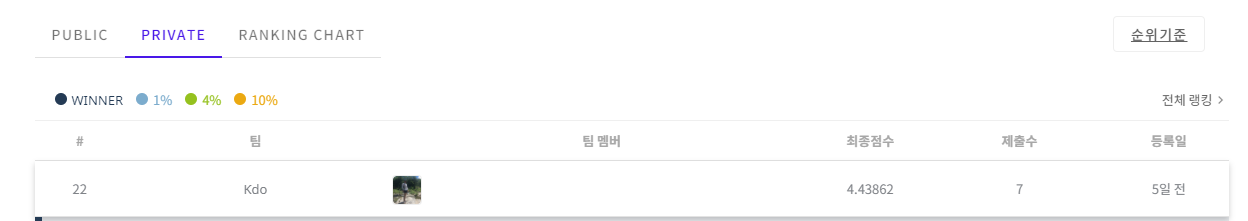

ARIMA_210.csv 최종 제출

상위 10%

# 결과 확인

In [10]:
result = pd.read_csv('../data/ARIMA_210.csv')
result.tail()

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
5,2021-11-29,31627.122248,31135.757092,59261.156577,130016.672347,122256.492790,15552.288166,44469.484613,80890.227458,116713.326438,...,44802.648663,49191.639540,103029.530549,39096.388319,19921.587646,51071.616486,377122.301327,277228.903681,24979.126280,16244.186543
6,2021-11-30,31678.350730,31153.571310,59155.386542,129689.842084,122751.468341,15556.269247,44334.690671,80948.441051,116578.779366,...,44865.357537,49238.838774,103373.525369,39058.675592,19960.652834,51041.675256,379449.096456,277759.587776,24968.316138,16297.176046
7,2021-12-01,31814.056531,31134.046105,59067.296840,129523.733045,122759.770641,15559.721993,44112.750570,81020.727912,116279.538243,...,44791.408730,49078.156051,103386.001032,39061.747799,19763.412716,50956.617256,379240.935938,277371.226140,24957.349924,16263.998030
8,2021-12-02,31873.526159,31130.261426,58988.636730,129355.806473,123100.459849,15565.008532,43978.515449,81092.775223,116355.621411,...,44749.310715,49065.339314,103662.934247,39045.749245,19569.656426,50947.712397,380222.401831,277334.002419,24945.724111,16243.958415
9,2021-12-03,31939.392356,31126.192548,58905.255558,129178.417483,123440.612054,15569.989160,43828.598231,81164.767530,116311.688706,...,44716.021424,49061.495631,103902.400699,39028.851448,19435.015655,50920.550088,381327.377071,277308.756563,24934.212127,16222.298014


In [7]:
start_date = '20210104'
end_date = '20211203'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

In [90]:
real_price1 = fdr.DataReader('000060', start = start_date, end = end_date)[['Close']].reset_index()
real_price1 = pd.merge(Business_days, real_price1, how = 'outer')
real_price1.set_index('Date', inplace=True)

real_price2 = fdr.DataReader('000080', start = start_date, end = end_date)[['Close']].reset_index()
real_price2 = pd.merge(Business_days, real_price2, how = 'outer')
real_price2.set_index('Date', inplace=True)

real_price3 = fdr.DataReader('000100', start = start_date, end = end_date)[['Close']].reset_index()
real_price3 = pd.merge(Business_days, real_price3, how = 'outer')
real_price3.set_index('Date', inplace=True)

In [91]:
prediction1 = pd.Series(result['000060'].iloc[-5:].values, index = real_price.tail().index)
prediction2 = pd.Series(result['000080'].iloc[-5:].values, index = real_price.tail().index)
prediction3 = pd.Series(result['000100'].iloc[-5:].values, index = real_price.tail().index)

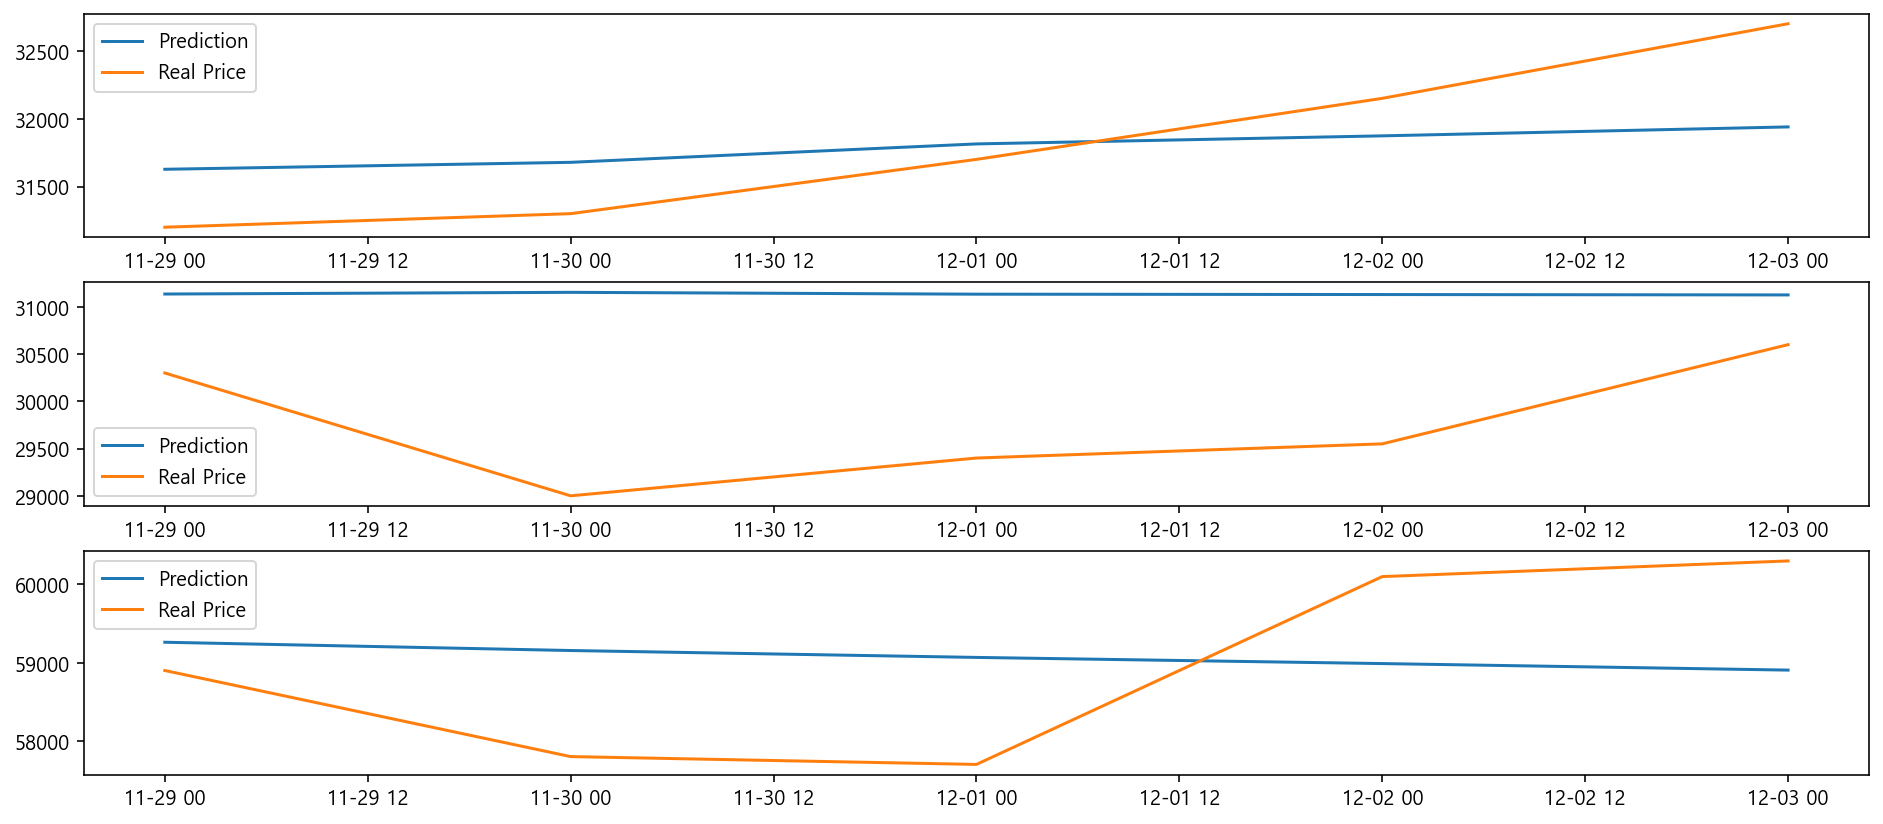

In [93]:
plt.figure(figsize=(16, 7))

plt.subplot(311)
plt.plot(prediction1, label='Prediction')
plt.plot(real_price1['Close'].iloc[-5:], label='Real Price')
plt.legend()

plt.subplot(312)
plt.plot(prediction2, label='Prediction')
plt.plot(real_price2['Close'].iloc[-5:], label='Real Price')
plt.legend()

plt.subplot(313)
plt.plot(prediction3, label='Prediction')
plt.plot(real_price3['Close'].iloc[-5:], label='Real Price')
plt.legend()

plt.show()

In [100]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


real_values = [real_price1.iloc[-5:], real_price2.iloc[-5:], real_price3.iloc[-5:]]
predictions = [prediction1, prediction2, prediction3]


for i,j in enumerate(real_values):
    mae = mean_absolute_error(j, predictions[i])
    mse = mean_squared_error(j, predictions[i])
    rmse = np.sqrt(mse)
    print('prediction : ',i+1)
    print('mae:' ,mae)
    print('mse:' ,mse)
    print('rmse:' ,rmse,'\n')

prediction :  1
mae: 391.32219892794967
mse: 198710.6710177139
rmse: 445.76975112462924 

prediction :  2
mae: 1365.965696043415
mse: 2223475.993638352
rmse: 1491.13245341866 

prediction :  3
mae: 1117.989533986684
mse: 1403489.554763219
rmse: 1184.6896449126325 

